In [1]:
import sys
sys.path.append('../utils')

import numpy as np
import pandas as pd
from matplotlib.cm import Dark2
import matplotlib.pyplot as plt
from util import get_missing_values, get_unique_val, get_max_class, imbalance_check
import seaborn as sns
import warnings
from collections import Counter
from imblearn.over_sampling import SMOTE
import joblib

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default='notebook'

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

from mlxtend.evaluate import mcnemar_table, mcnemar_tables
from mlxtend.plotting import checkerboard_plot

pd.set_option('display.max_columns', 35)
plt.style.use('dark_background')
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False
warnings.filterwarnings('ignore')

In [2]:
# read data in to df
df_rta = pd.read_csv("../data/RTA_dataset.csv")
df_rta.head()

Time Day_of_week Age_band_of_driver Sex_of_driver   Educational_level  \
0  17:02:00      Monday              18-30          Male   Above high school   
1  17:02:00      Monday              31-50          Male  Junior high school   
2  17:02:00      Monday              18-30          Male  Junior high school   
3   1:06:00      Sunday              18-30          Male  Junior high school   
4   1:06:00      Sunday              18-30          Male  Junior high school   

  Vehicle_driver_relation Driving_experience      Type_of_vehicle  \
0                Employee              1-2yr           Automobile   
1                Employee         Above 10yr  Public (> 45 seats)   
2                Employee              1-2yr      Lorry (41?100Q)   
3                Employee             5-10yr  Public (> 45 seats)   
4                Employee              2-5yr                  NaN   

  Owner_of_vehicle Service_year_of_vehicle Defect_of_vehicle  \
0            Owner              Above 10yr         No defect   
1            Owner                 5-10yrs         No defect   
2            Owner                     NaN         No defect   
3     Governmental                     NaN         No defect   
4            Owner                 5-10yrs         No defect   

  Area_accident_occured   Lanes_or_Medians  \
0     Residential areas                NaN   
1          Office areas  Undivided Two way   
2    Recreational areas              other   
3          Office areas              other   
4      Industrial areas              other   

                                 Road_allignment Types_of_Junction  \
0                 Tangent road with flat terrain       No junction   
1                 Tangent road with flat terrain       No junction   
2                                            NaN       No junction   
3  Tangent road with mild grade and flat terrain           Y Shape   
4                 Tangent road with flat terrain           Y Shape   

  Road_surface_type Road_surface_conditions       Light_conditions  \
0     Asphalt roads                     Dry               Daylight   
1     Asphalt roads                     Dry               Daylight   
2     Asphalt roads                     Dry               Daylight   
3       Earth roads                     Dry  Darkness - lights lit   
4     Asphalt roads                     Dry  Darkness - lights lit   

  Weather_conditions                        Type_of_collision  \
0             Normal  Collision with roadside-parked vehicles   
1             Normal           Vehicle with vehicle collision   
2             Normal          Collision with roadside objects   
3             Normal           Vehicle with vehicle collision   
4             Normal           Vehicle with vehicle collision   

   Number_of_vehicles_involved  Number_of_casualties Vehicle_movement  \
0                            2                     2   Going straight   
1                            2                     2   Going straight   
2                            2                     2   Going straight   
3                            2                     2   Going straight   
4                            2                     2   Going straight   

    Casualty_class Sex_of_casualty Age_band_of_casualty Casualty_severity  \
0               na              na                   na                na   
1               na              na                   na                na   
2  Driver or rider            Male                31-50                 3   
3       Pedestrian          Female                18-30                 3   
4               na              na                   na                na   

  Work_of_casuality Fitness_of_casuality Pedestrian_movement  \
0               NaN                  NaN    Not a Pedestrian   
1               NaN                  NaN    Not a Pedestrian   
2            Driver                  NaN    Not a Pedestrian   
3            Driver               Normal    Not a Pedestri

In [3]:
df_rta.shape

(12316, 32)

In [4]:
df_rta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            11575 non-null  object
 5   Vehicle_driver_relation      11737 non-null  object
 6   Driving_experience           11487 non-null  object
 7   Type_of_vehicle              11366 non-null  object
 8   Owner_of_vehicle             11834 non-null  object
 9   Service_year_of_vehicle      8388 non-null   object
 10  Defect_of_vehicle            7889 non-null   object
 11  Area_accident_occured        12077 non-null  object
 12  Lanes_or_Medians             11931 non-null  object
 13  Road_allignment              12

In [5]:
df_rta.columns

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

In [6]:
# rename columns
ren_col_map = {
    'Time': 'time', 
    'Day_of_week': 'day_of_week', 
    'Age_band_of_driver': 'driver_age', 
    'Sex_of_driver': 'driver_sex',
    'Educational_level': 'educational_level', 
    'Vehicle_driver_relation': 'vehicle_driver_relation', 
    'Driving_experience': 'driving_experience',
    'Type_of_vehicle': 'vehicle_type',
    'Owner_of_vehicle': 'vehicle_owner',
    'Service_year_of_vehicle': 'service_year',
    'Defect_of_vehicle': 'vehicle_defect',
    'Area_accident_occured': 'accident_area',
    'Lanes_or_Medians': 'lanes',
    'Road_allignment': 'road_alignment',
    'Types_of_Junction': 'junction_type',
    'Road_surface_type': 'surface_type',
    'Road_surface_conditions': 'surface_condition',
    'Light_conditions': 'light_condition',
    'Weather_conditions': 'weather_condition',
    'Type_of_collision': 'collision_type',
    'Number_of_vehicles_involved': 'vehicles_involved',
    'Number_of_casualties': 'casualties',
    'Vehicle_movement': 'vehicle_movement',
    'Casualty_class': 'casualty_class',
    'Sex_of_casualty': 'casualty_sex',
    'Age_band_of_casualty': 'casualty_age',
    'Casualty_severity': 'casualty_severity',
    'Work_of_casuality': 'casuality_work',
    'Fitness_of_casuality': 'casuality_fitness',
    'Pedestrian_movement': 'pedestrian_movement',
    'Cause_of_accident': 'accident_cause',
    'Accident_severity': 'accident_severity'
}

df_rta.rename(columns=ren_col_map, inplace=True)

In [7]:
df_rta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   time                     12316 non-null  object
 1   day_of_week              12316 non-null  object
 2   driver_age               12316 non-null  object
 3   driver_sex               12316 non-null  object
 4   educational_level        11575 non-null  object
 5   vehicle_driver_relation  11737 non-null  object
 6   driving_experience       11487 non-null  object
 7   vehicle_type             11366 non-null  object
 8   vehicle_owner            11834 non-null  object
 9   service_year             8388 non-null   object
 10  vehicle_defect           7889 non-null   object
 11  accident_area            12077 non-null  object
 12  lanes                    11931 non-null  object
 13  road_alignment           12174 non-null  object
 14  junction_type            11429 non-nul

In [8]:
# convert column with dtype object to category
for col in df_rta.drop(['time', 'vehicles_involved', 'casualties'], axis=1):
    df_rta[col] = df_rta[col].astype('category')

In [9]:
# convert time column to datetime
df_rta['time'] = pd.to_datetime(df_rta['time'])

In [10]:
df_rta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   time                     12316 non-null  datetime64[ns]
 1   day_of_week              12316 non-null  category      
 2   driver_age               12316 non-null  category      
 3   driver_sex               12316 non-null  category      
 4   educational_level        11575 non-null  category      
 5   vehicle_driver_relation  11737 non-null  category      
 6   driving_experience       11487 non-null  category      
 7   vehicle_type             11366 non-null  category      
 8   vehicle_owner            11834 non-null  category      
 9   service_year             8388 non-null   category      
 10  vehicle_defect           7889 non-null   category      
 11  accident_area            12077 non-null  category      
 12  lanes                    11931 n

In [11]:
# check for duplicates
df_rta.duplicated().sum()

0

In [12]:
# check if any feature has the same constant value
[col for col in df_rta.columns if df_rta[col].nunique() == 1]

[]

In [13]:
df_rta.describe(datetime_is_numeric=True).T

count                           mean  \
time                 12316  2024-06-21 14:17:50.768106496   
vehicles_involved  12316.0                       2.040679   
casualties         12316.0                       1.548149   

                                   min                  25%  \
time               2024-06-21 00:01:00  2024-06-21 10:31:00   
vehicles_involved                  1.0                  2.0   
casualties                         1.0                  1.0   

                                   50%                  75%  \
time               2024-06-21 15:10:00  2024-06-21 18:10:00   
vehicles_involved                  2.0                  2.0   
casualties                         1.0                  2.0   

                                   max       std  
time               2024-06-21 23:59:00       NaN  
vehicles_involved                  7.0   0.68879  
casualties                         8.0  1.007179

In [14]:
df_rta.describe(include='category').T

count unique  \
day_of_week              12316      7   
driver_age               12316      5   
driver_sex               12316      3   
educational_level        11575      7   
vehicle_driver_relation  11737      4   
driving_experience       11487      7   
vehicle_type             11366     17   
vehicle_owner            11834      4   
service_year              8388      6   
vehicle_defect            7889      3   
accident_area            12077     14   
lanes                    11931      7   
road_alignment           12174      9   
junction_type            11429      8   
surface_type             12144      5   
surface_condition        12316      4   
light_condition          12316      4   
weather_condition        12316      9   
collision_type           12161     10   
vehicle_movement         12008     13   
casualty_class           12316      4   
casualty_sex             12316      3   
casualty_age             12316      6   
casualty_severity        12316      4   
casuality_work            9118      7   
casuality_fitness         9681      5   
pedestrian_movement      12316      9   
accident_cause           12316     20   
accident_severity        12316      3   

                                                                      top  \
day_of_week                                                        Friday   
driver_age                                                          18-30   
driver_sex                                                           Male   
educational_level                                      Junior high school   
vehicle_driver_relation                                          Employee   
driving_experience                                                 5-10yr   
vehicle_type                                                   Automobile   
vehicle_owner                                                       Owner   
service_year                                                      Unknown   
vehicle_defect                                                  No defect   
accident_area                                                       Other   
lanes                    Two-way (divided with broken lines road marking)   
road_alignment                             Tangent road with flat terrain   
junction_type                                                     Y Shape   
surface_type                                                Asphalt roads   
surface_condition                                                     Dry   
light_condition                                                  Daylight   
weather_condition                                                  Normal   
collision_type                             Vehicle with vehicle collision   
vehicle_movement                                           Going straight   
casualty_class                                            Driver or rider   
casualty_sex                                                         Male   
casualty_age                                                           na   
casualty_severity                                                       3   
casuality_work                                                     Driver   
casuality_fitness                                                  Normal   
pedestrian_movement                                      Not a Pedestrian   
accident_cause                                              No distancing   
accident_severity                                           Slight Injury   

                          freq  
day_of_week               2041  
driver_age                4271  
driver_sex               11437  
educational_level         7619  
vehicle_driver_relation   9627  
driving_experience        3363  
vehicle_type              3205  
vehicle_owner            10459  
service_year              2883  
vehicle_defect            7777  
accident_area             3819  
lanes                     4411  
road_alignment           10459  
junction_type        

In [15]:
df_rta.describe(include='all')

time day_of_week driver_age driver_sex  \
count                 12316       12316      12316      12316   
unique                 1074           7          5          3   
top     2024-06-21 15:30:00      Friday      18-30       Male   
freq                    120        2041       4271      11437   
first   2024-06-21 00:01:00         NaN        NaN        NaN   
last    2024-06-21 23:59:00         NaN        NaN        NaN   
mean                    NaN         NaN        NaN        NaN   
std                     NaN         NaN        NaN        NaN   
min                     NaN         NaN        NaN        NaN   
25%                     NaN         NaN        NaN        NaN   
50%                     NaN         NaN        NaN        NaN   
75%                     NaN         NaN        NaN        NaN   
max                     NaN         NaN        NaN        NaN   

         educational_level vehicle_driver_relation driving_experience  \
count                11575                   11737              11487   
unique                   7                       4                  7   
top     Junior high school                Employee             5-10yr   
freq                  7619                    9627               3363   
first                  NaN                     NaN                NaN   
last                   NaN                     NaN                NaN   
mean                   NaN                     NaN                NaN   
std                    NaN                     NaN                NaN   
min                    NaN                     NaN                NaN   
25%                    NaN                     NaN                NaN   
50%                    NaN                     NaN                NaN   
75%                    NaN                     NaN                NaN   
max                    NaN                     NaN                NaN   

       vehicle_type vehicle_owner service_year vehicle_defect accident_area  \
count         11366         11834         8388           7889         12077   
unique           17             4            6              3            14   
top      Automobile         Owner      Unknown      No defect         Other   
freq           3205         10459         2883           7777          3819   
first           NaN           NaN          NaN            NaN           NaN   
last            NaN           NaN          NaN            NaN           NaN   
mean            NaN           NaN          NaN            NaN           NaN   
std             NaN           NaN          NaN            NaN           NaN   
min             NaN           NaN          NaN            NaN           NaN   
25%             NaN           NaN          NaN            NaN           NaN   
50%             NaN           NaN          NaN            NaN           NaN   
75%             NaN           NaN          NaN            NaN           NaN   
max             NaN           NaN          NaN            NaN           NaN   

                                                   lanes  \
count                                              11931   
unique                                                 7   
top     Two-way (divided with broken lines road marking)   
freq                                                4411   
first                                                NaN   
last                                                 NaN   
mean                                                 NaN   
std                                                  NaN   
min                                                  NaN   
25%                                                  NaN   
50%                                                  NaN   
75%                                                  NaN   
max                                                  NaN   

                        road_alignment junction_type   surface_type  \
count                            12174         11429          12144   

In [16]:
# get unique values along with percentage count for categorical variables
for col in df_rta.columns:
    if isinstance(df_rta[col].dtype, pd.CategoricalDtype):
        print('-' * 30)
        print(col)
        print('-' * 30)
        print(get_unique_val(df_rta[col]))
        

------------------------------
day_of_week
------------------------------
Friday       16.57
Thursday     15.03
Wednesday    14.94
Tuesday      14.37
Monday       13.65
Saturday     13.53
Sunday       11.91
Name: day_of_week, dtype: float64
------------------------------
driver_age
------------------------------
18-30       34.68
31-50       33.18
Over 51     12.87
Unknown     12.57
Under 18     6.70
Name: driver_age, dtype: float64
------------------------------
driver_sex
------------------------------
Male       92.86
Female      5.69
Unknown     1.45
Name: driver_sex, dtype: float64
------------------------------
educational_level
------------------------------
Junior high school    61.86
Elementary school     17.56
High school            9.01
NaN                    6.02
Above high school      2.94
Writing & reading      1.43
Unknown                0.81
Illiterate             0.37
Name: educational_level, dtype: float64
------------------------------
vehicle_driver_relation
-------

### Observations
write obs here

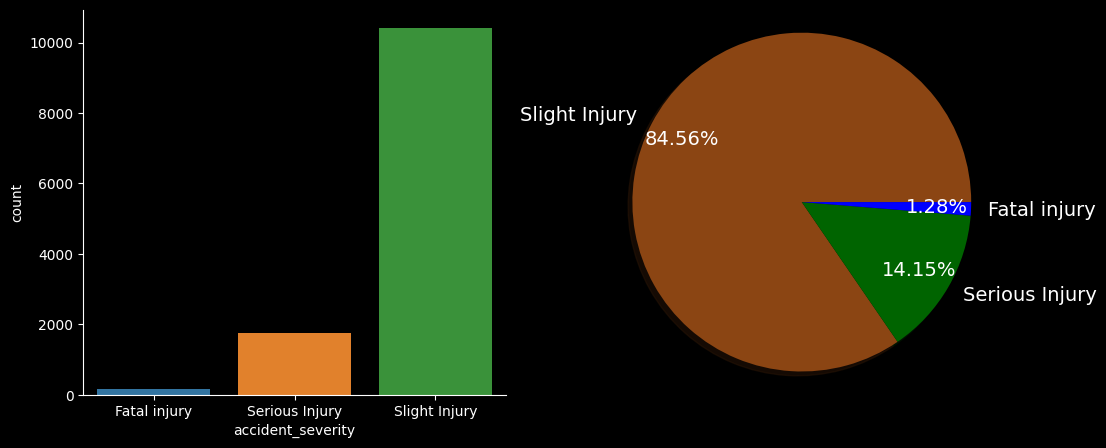

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

sns.countplot(data=df_rta, x=df_rta['accident_severity'], hue=df_rta['accident_severity'], palette='tab10', legend=False, ax=ax1)

ax2.pie(df_rta['accident_severity'].value_counts(),
        labels=list(df_rta['accident_severity'].unique()),
        colors=['saddlebrown', 'darkgreen', 'blue'],
        autopct='%1.2f%%',
        pctdistance=0.8,
        shadow=True,
        radius=1.1,
        textprops={'fontsize':14},
        )

plt.show()

The target column is imbalanced and requires resampling

In [18]:
fig = px.treemap(df_rta, path=['accident_cause'], width=800, height=400)
fig.update_layout(
    margin = dict(t=50, l=25, r=25, b=25))
fig.show()

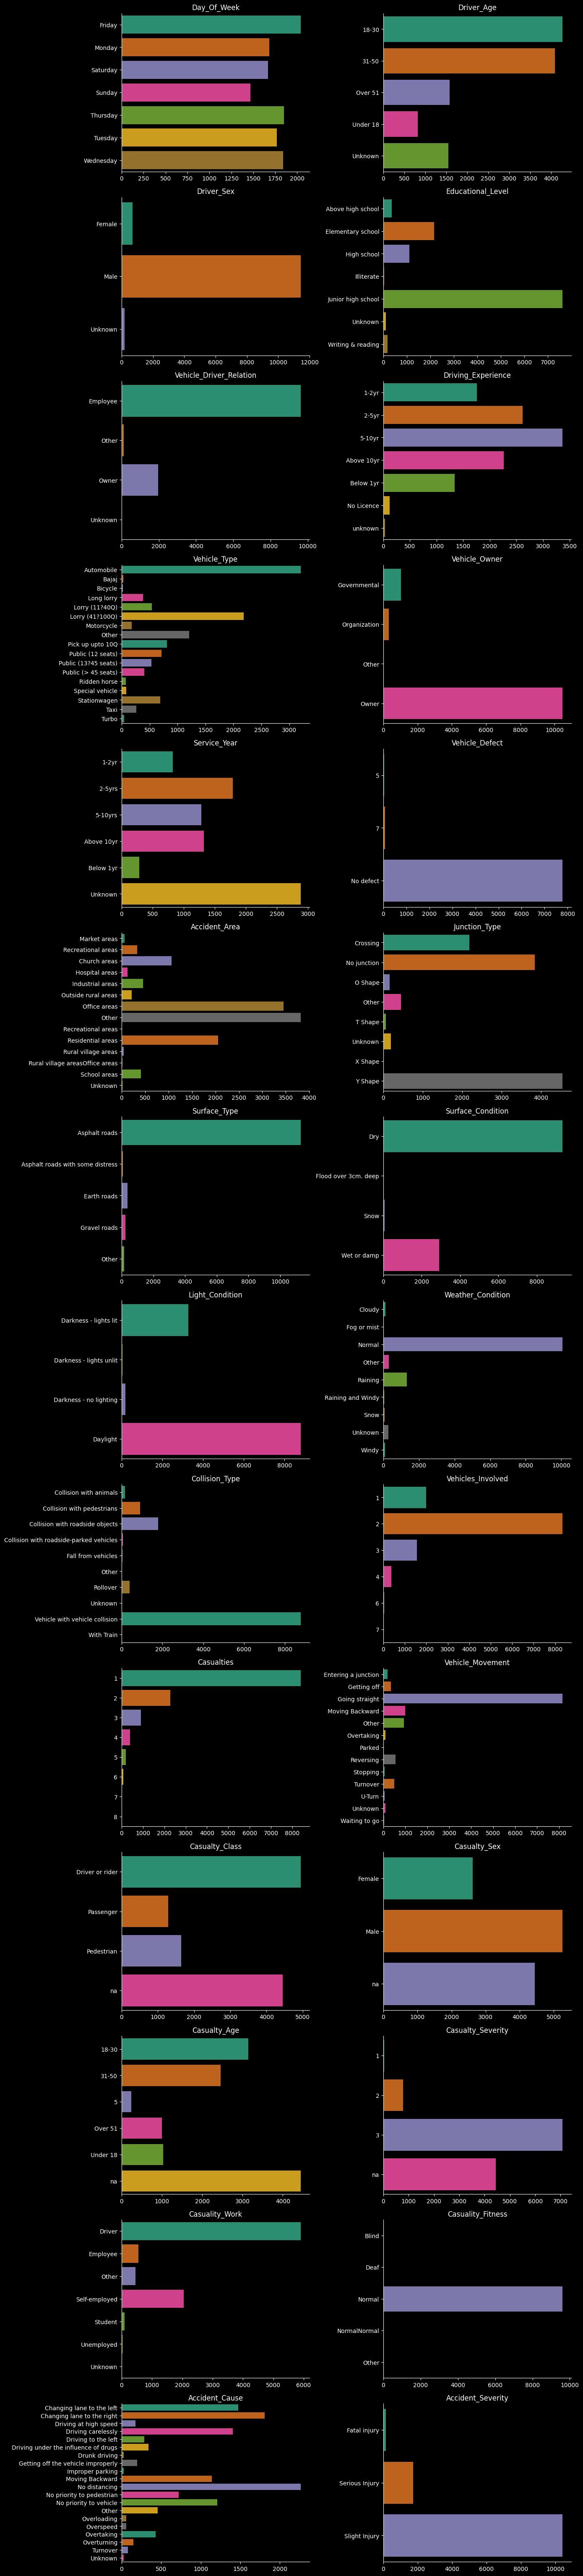

In [19]:
plt.figure(figsize=(14,70))
plot_num = 1

for col in df_rta.drop(['time', 'lanes', 'road_alignment', 'pedestrian_movement'], axis=1):
    if plot_num <= df_rta.shape[1]:
        ax1 = plt.subplot(16, 2, plot_num)
        sns.countplot(data=df_rta, y=col, hue=col, palette='Dark2', legend=False, ax=ax1)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.title(col.title(), fontsize=12)
        plt.xlabel('')
        plt.ylabel('')
    plot_num += 1

plt.tight_layout()

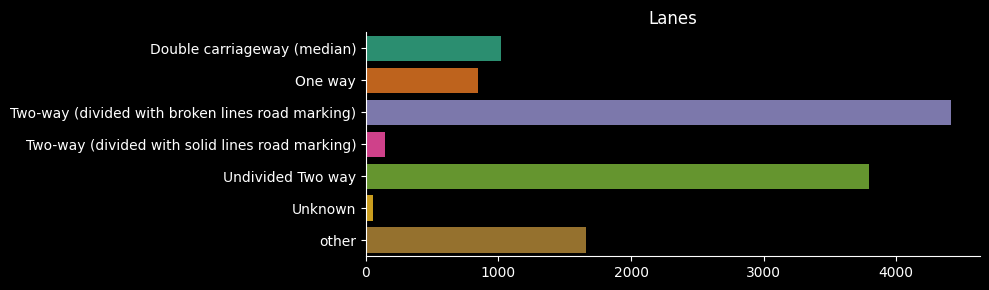

In [20]:
plt.figure(figsize=(10,3))
sns.countplot(data=df_rta, y='lanes', hue='lanes', legend=False, palette='Dark2')
plt.title('Lanes', fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

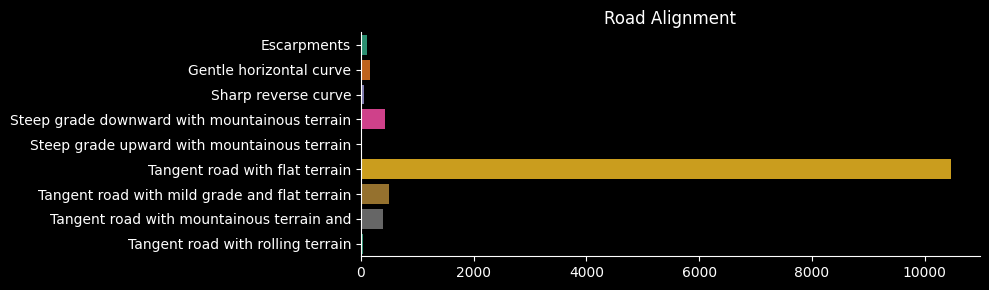

In [21]:
plt.figure(figsize=(10,3))
sns.countplot(data=df_rta, y='road_alignment', hue='road_alignment', legend=False, palette='Dark2')
plt.title('Road Alignment', fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

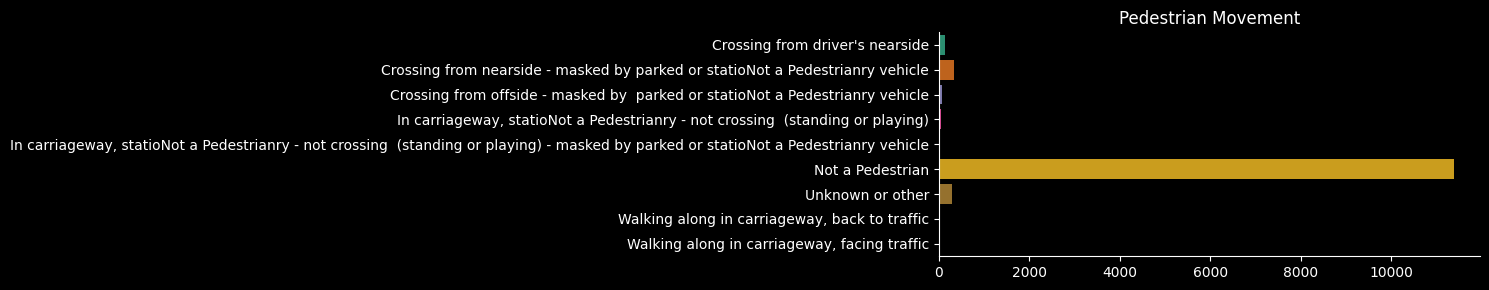

In [22]:
plt.figure(figsize=(15,3))
sns.countplot(data=df_rta, y='pedestrian_movement', hue='pedestrian_movement', legend=False, palette='Dark2')
plt.title('Pedestrian Movement', fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

In [23]:
# Add hour and minute, drop time column
df_rta['hour'] = df_rta['time'].dt.hour
df_rta.drop('time', axis=1, inplace=True)

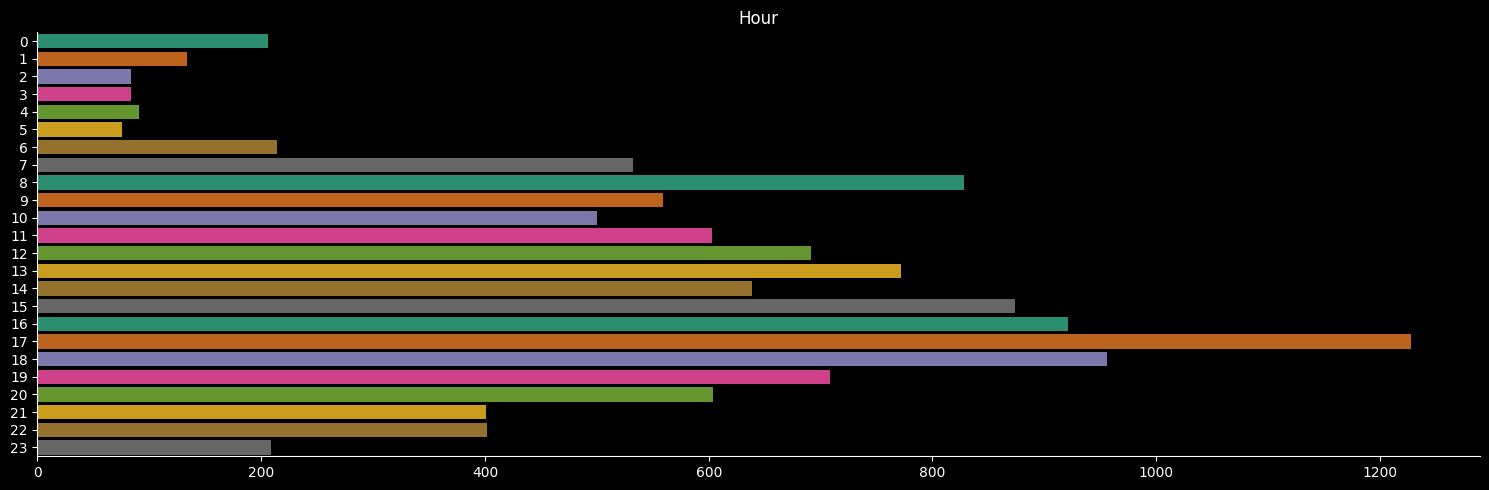

In [24]:
plt.figure(figsize=(15,5))
sns.countplot(data=df_rta, y='hour', hue='hour', legend=False, palette='Dark2')
plt.title('Hour', fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

<Figure size 1500x300 with 0 Axes>

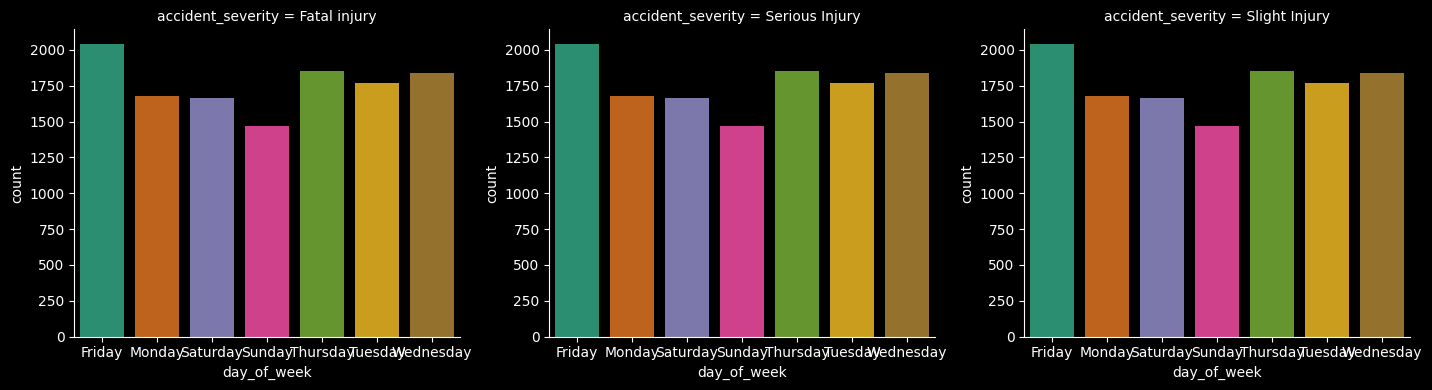

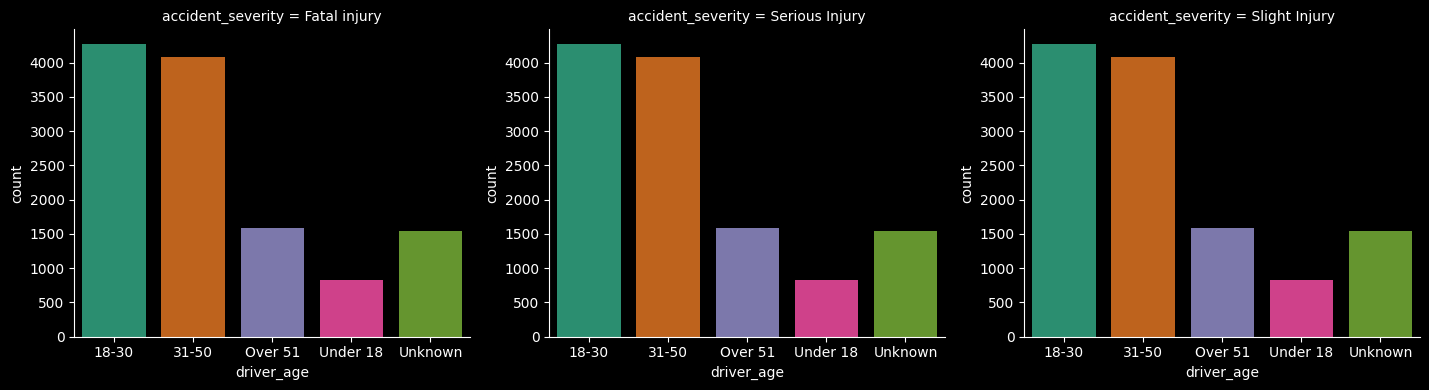

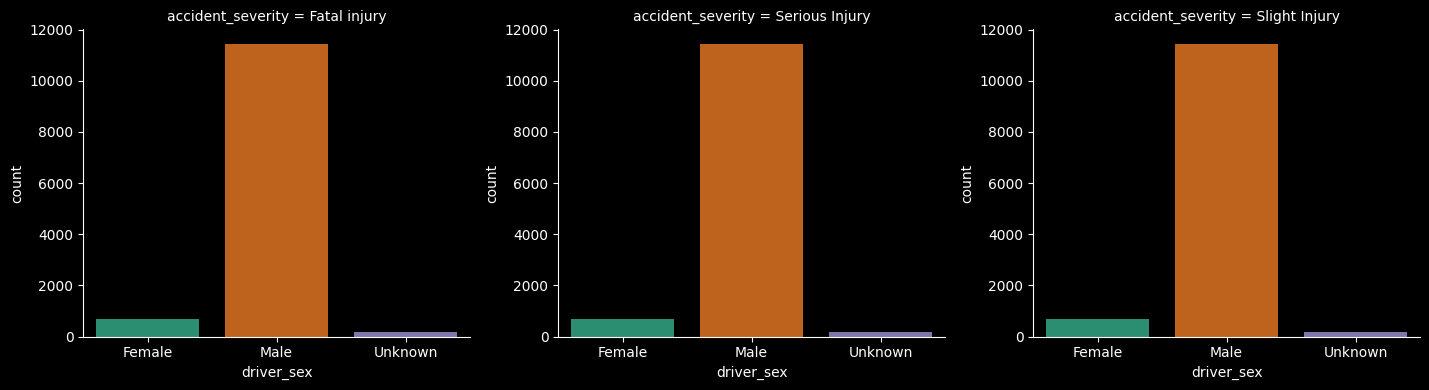

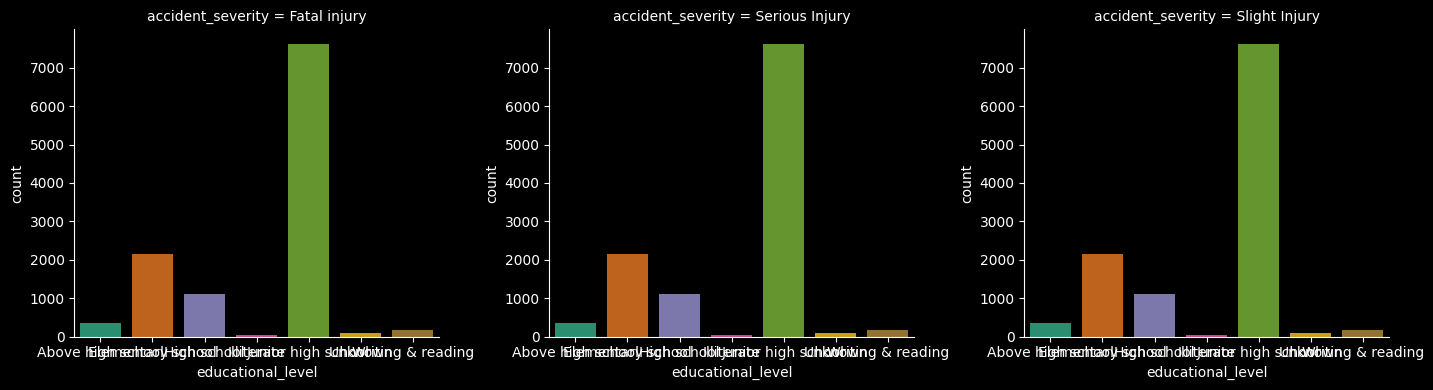

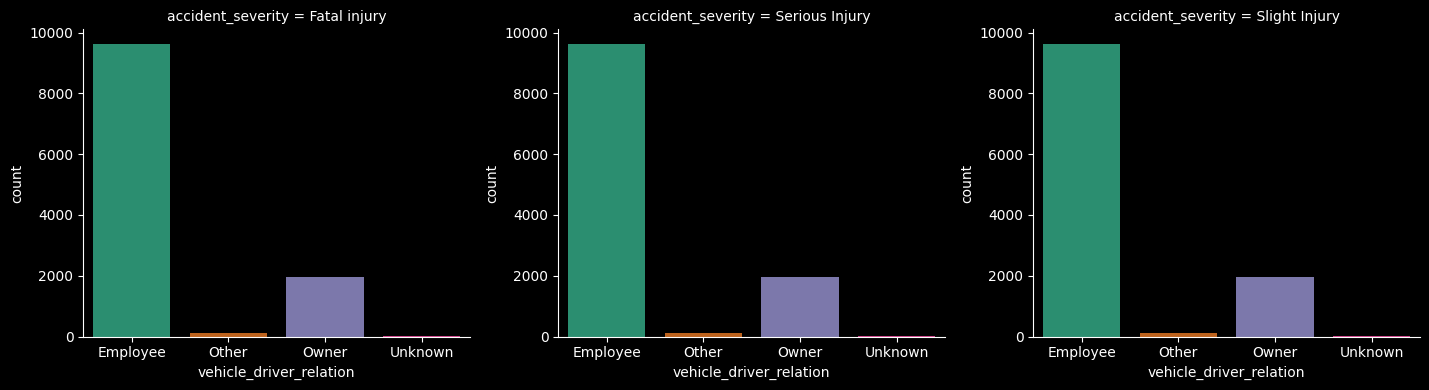

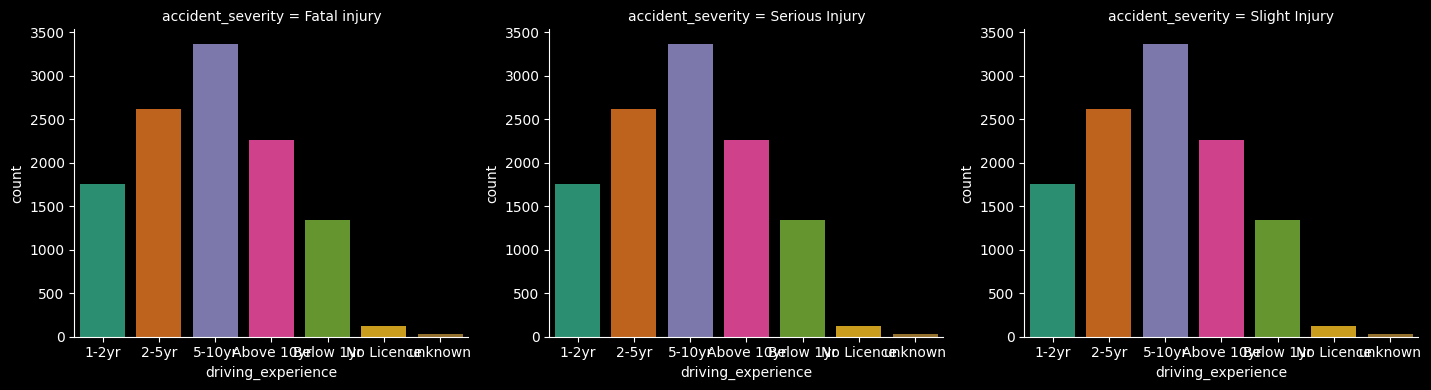

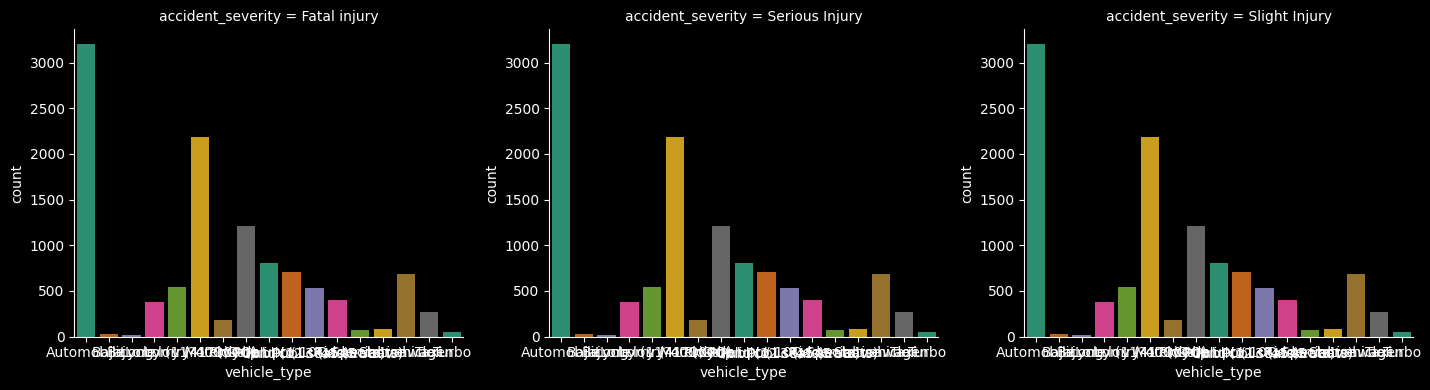

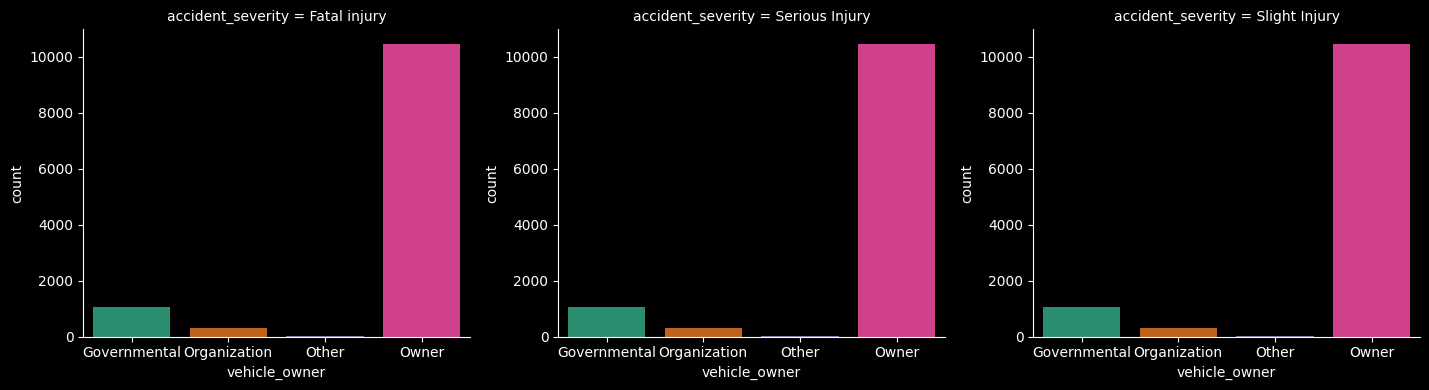

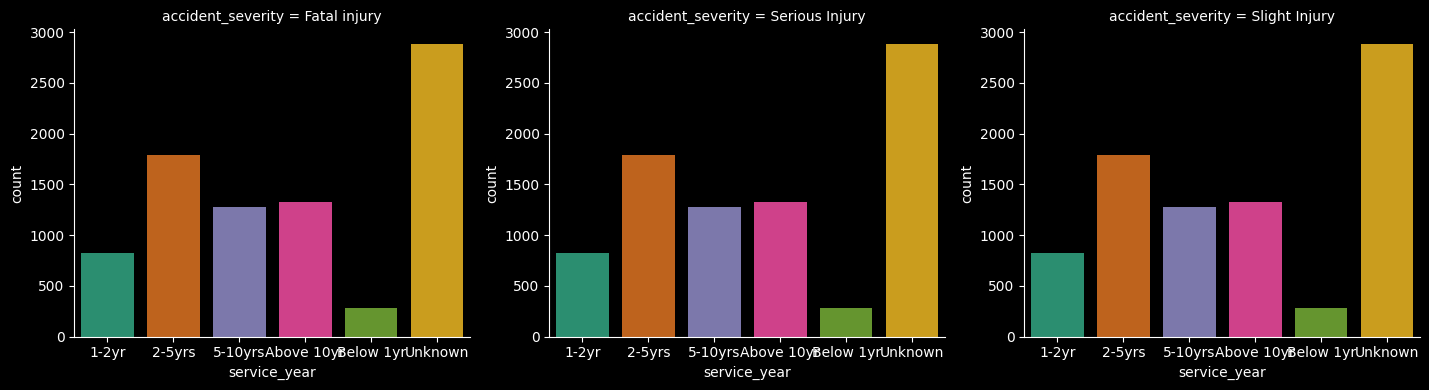

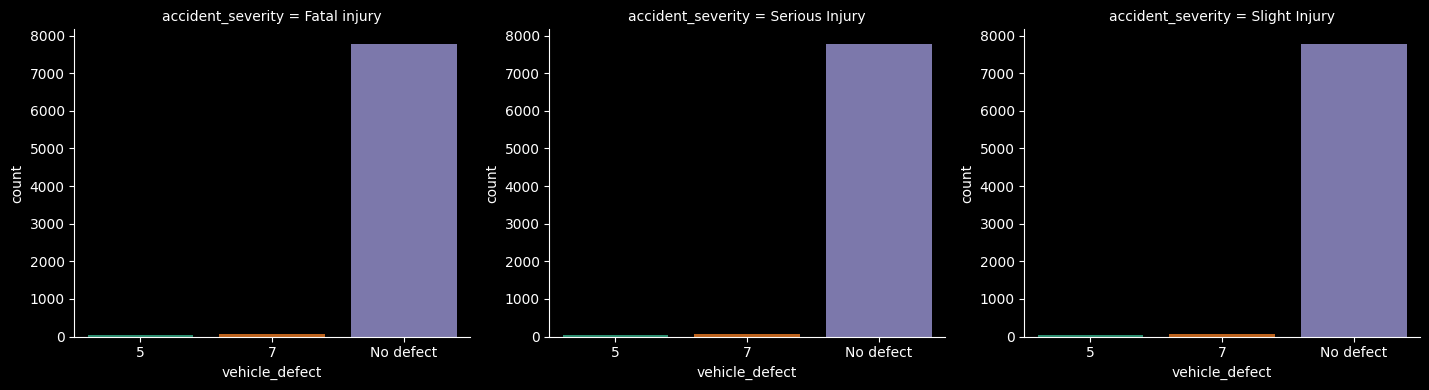

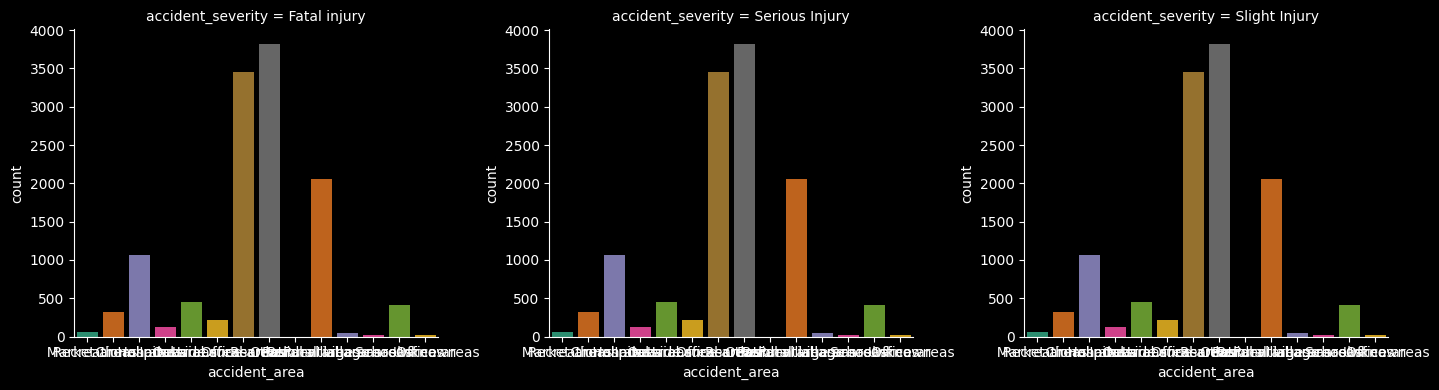

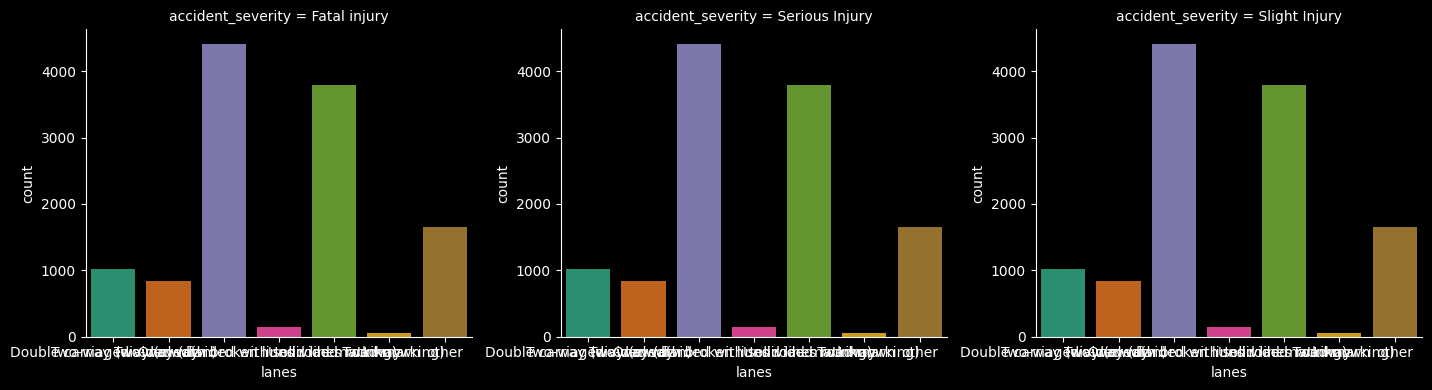

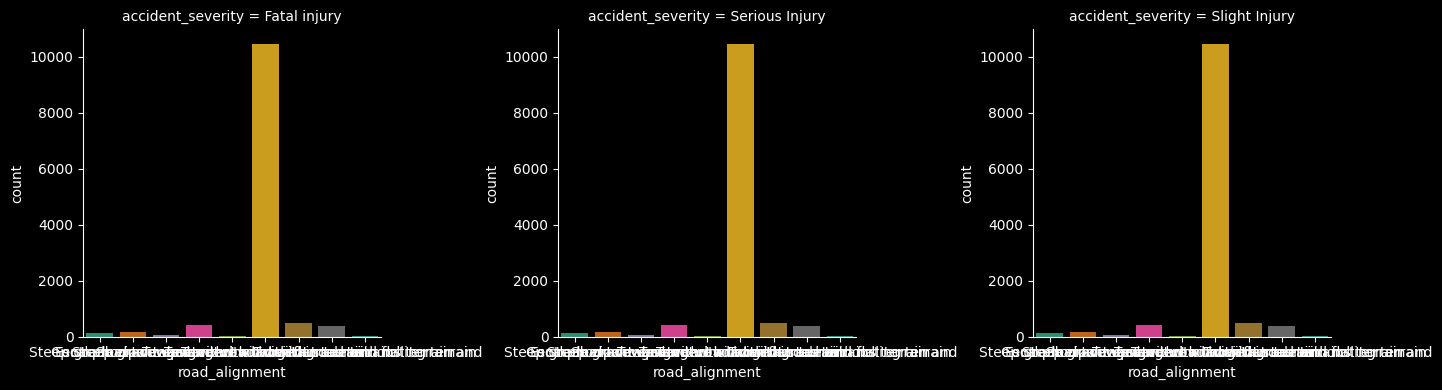

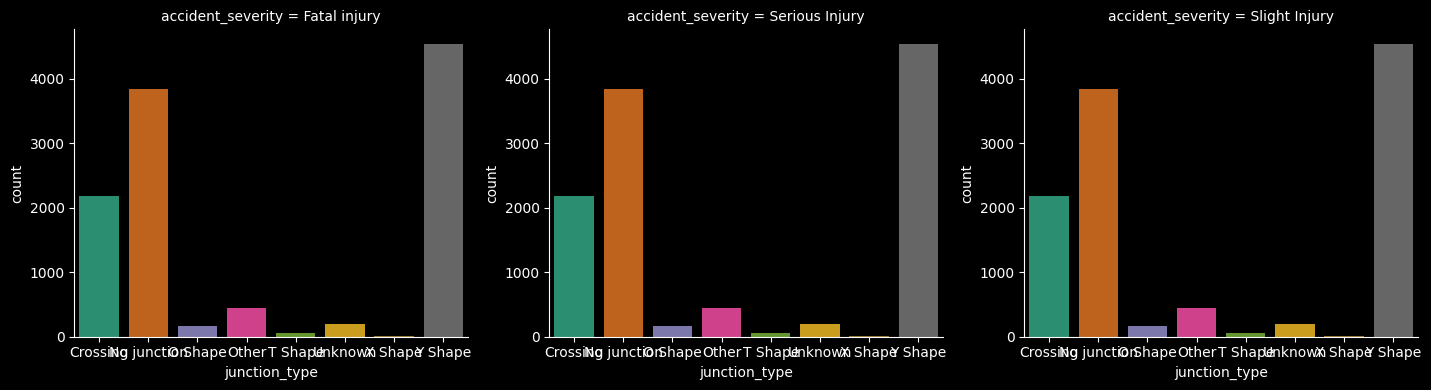

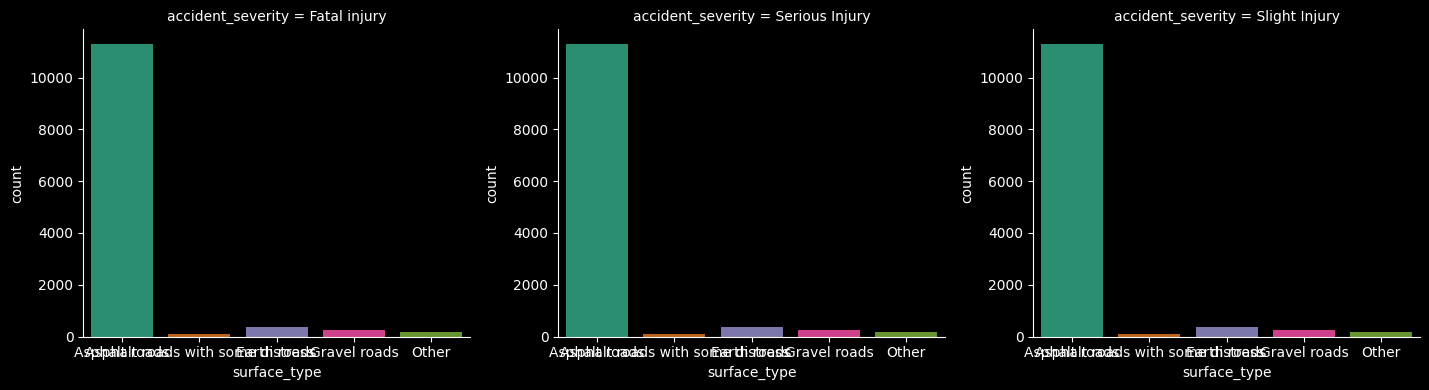

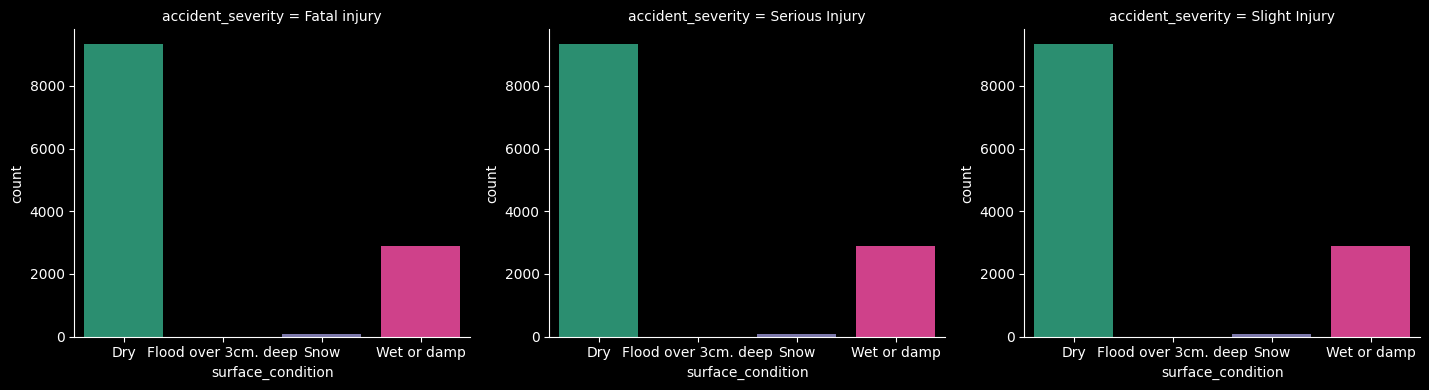

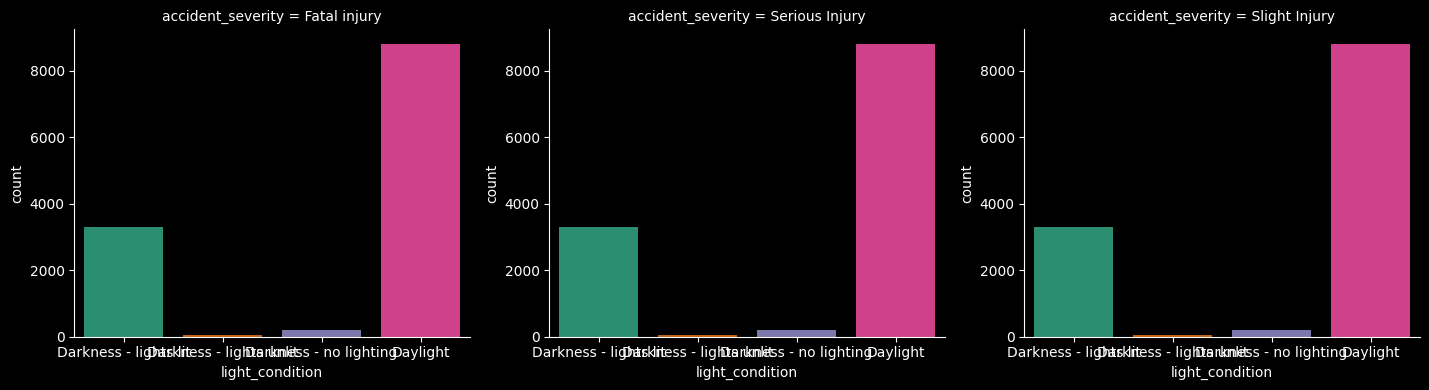

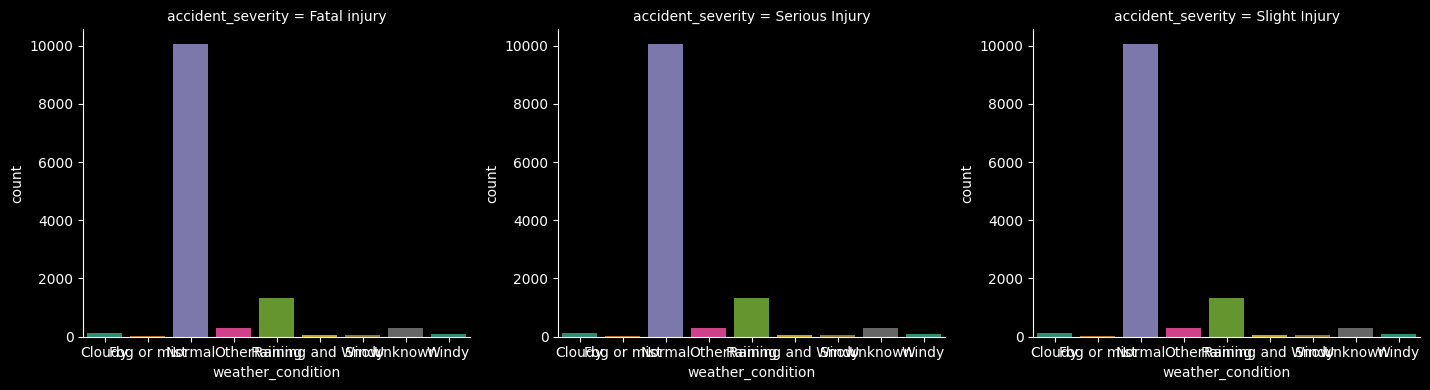

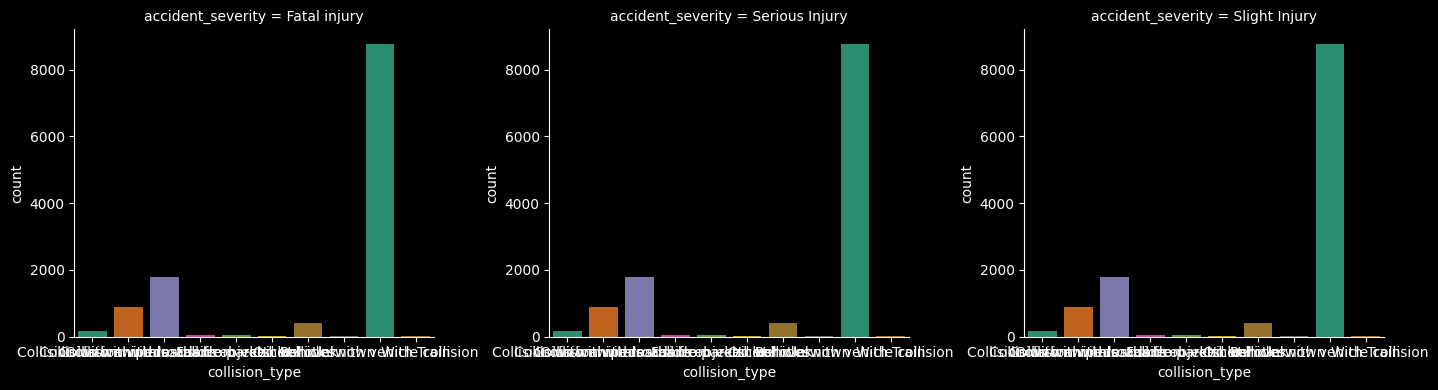

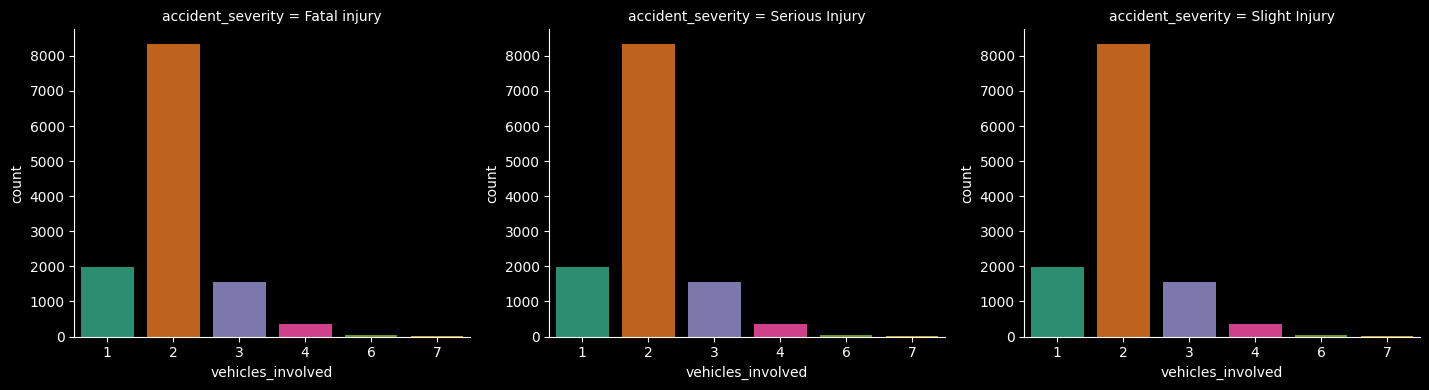

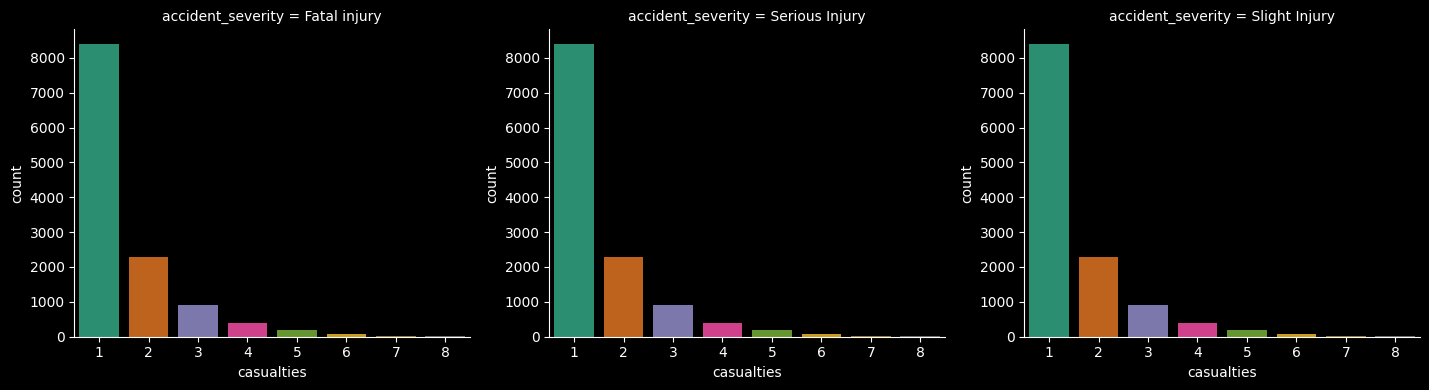

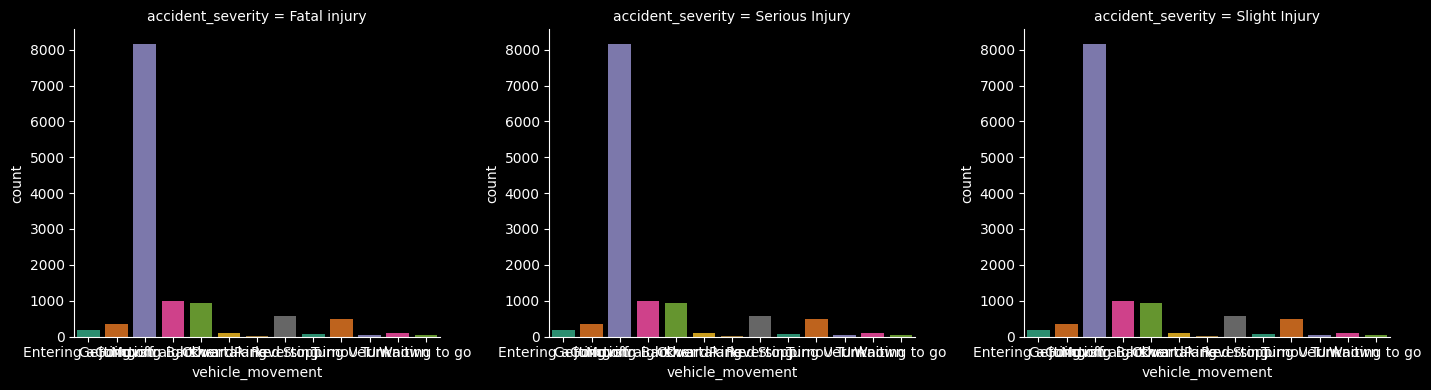

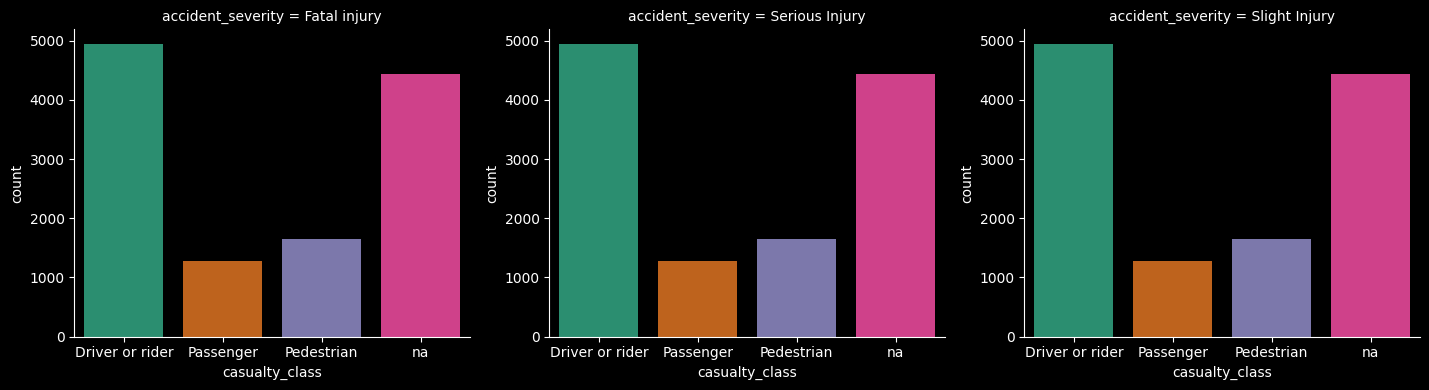

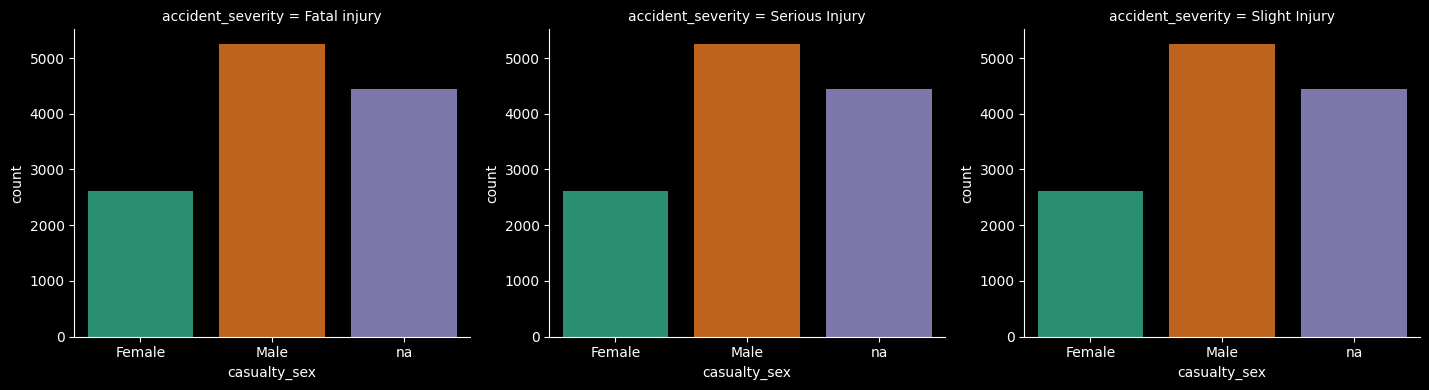

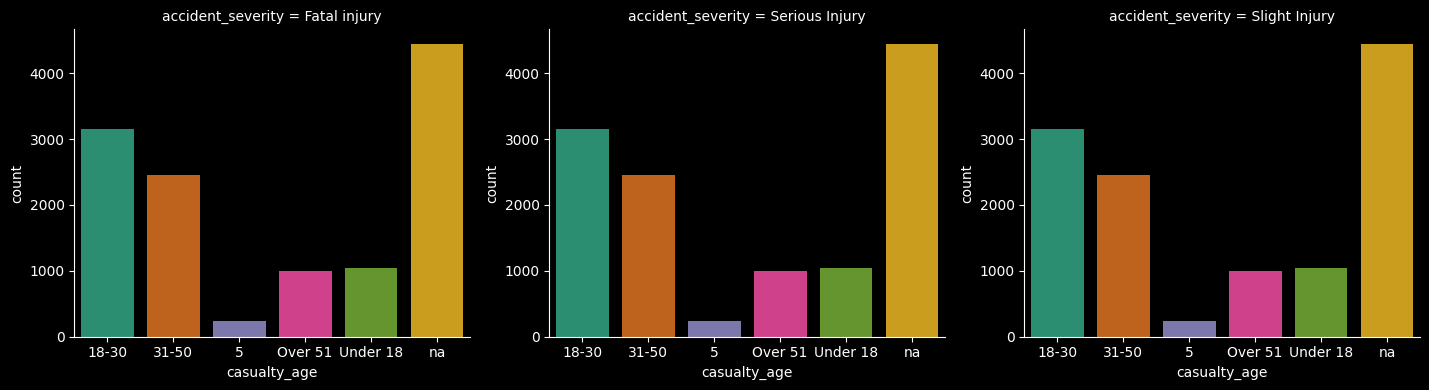

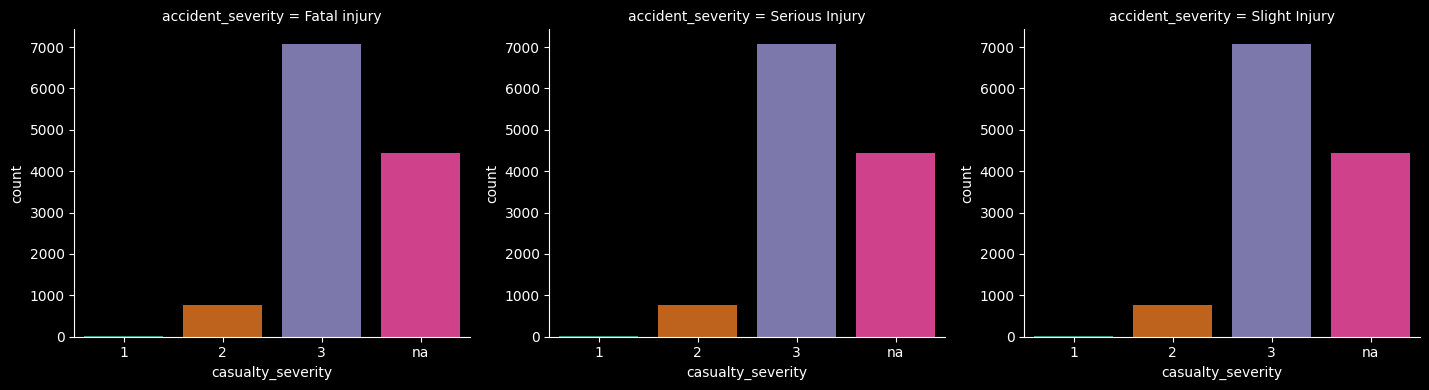

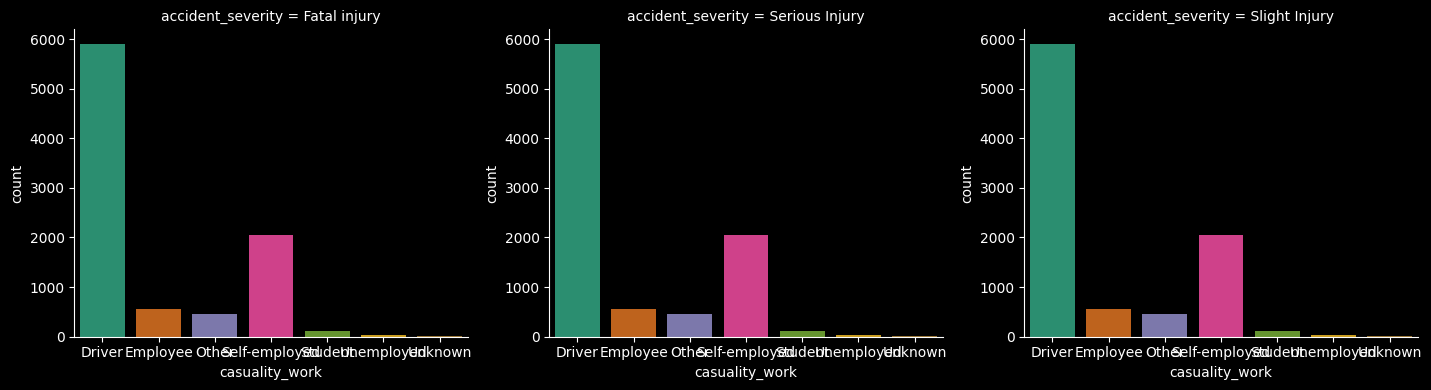

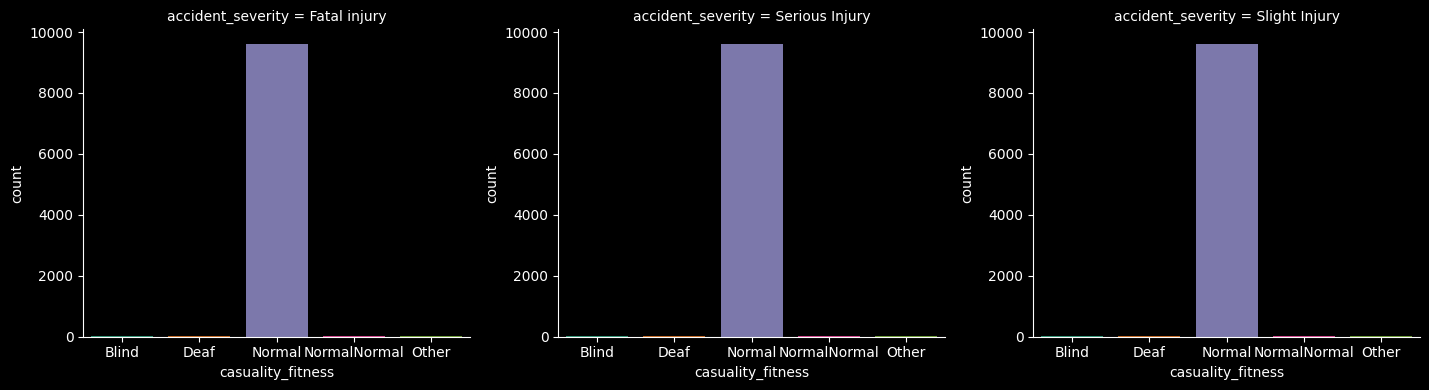

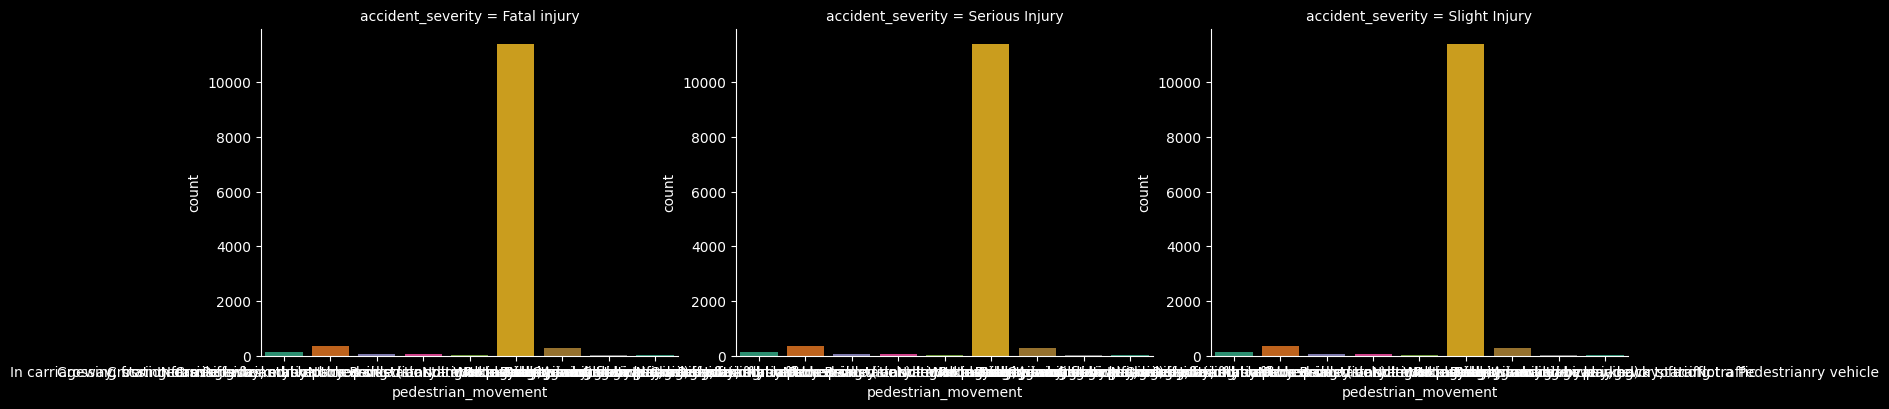

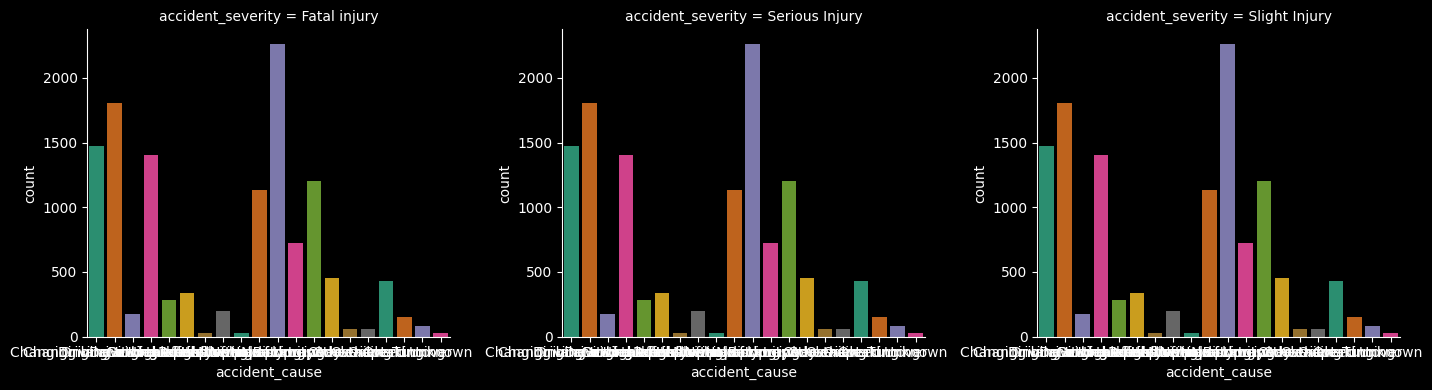

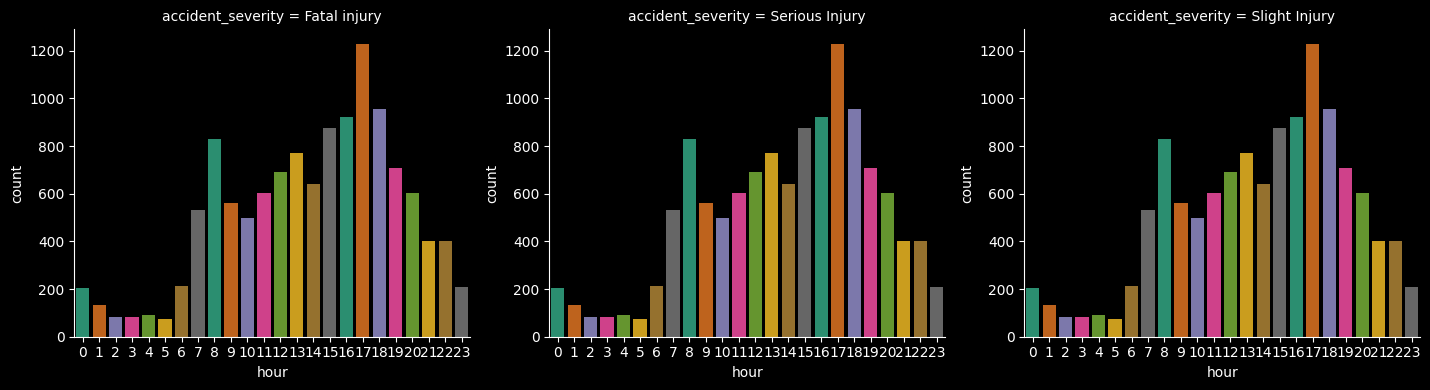

In [25]:
plt.figure(figsize=(15,3))
for col in df_rta.drop('accident_severity', axis=1):
    g = sns.FacetGrid(df_rta, col='accident_severity', height=4, aspect=1.2, sharey=False)
    g.map(sns.countplot, data=df_rta, x=col, hue=col, legend=False, palette='Dark2')
    plt.show()

### Pre-processing

In [26]:
# Rearranging columns
cols = ['hour', 'day_of_week', 'driver_age', 'driver_sex', 'educational_level',
       'vehicle_driver_relation', 'driving_experience', 'vehicle_type',
       'vehicle_owner', 'service_year', 'vehicle_defect', 'accident_area',
       'lanes', 'road_alignment', 'junction_type', 'surface_type',
       'surface_condition', 'light_condition', 'weather_condition',
       'collision_type', 'vehicles_involved', 'casualties', 'vehicle_movement',
       'casualty_class', 'casualty_sex', 'casualty_age', 'casualty_severity',
       'casuality_work', 'casuality_fitness', 'pedestrian_movement',
       'accident_cause', 'accident_severity']

df_rta = df_rta[cols]

##### Impute missing values

In [27]:
# get missing values info
df_miss_val = get_missing_values(df_rta)
df_miss_val

col     dtype  miss_val  pct_miss_val
0            vehicle_defect  category      4427         35.95
1              service_year  category      3928         31.89
2            casuality_work  category      3198         25.97
3         casuality_fitness  category      2635         21.39
4              vehicle_type  category       950          7.71
5             junction_type  category       887          7.20
6        driving_experience  category       829          6.73
7         educational_level  category       741          6.02
8   vehicle_driver_relation  category       579          4.70
9             vehicle_owner  category       482          3.91
10                    lanes  category       385          3.13
11         vehicle_movement  category       308          2.50
12            accident_area  category       239          1.94
13             surface_type  category       172          1.40
14           collision_type  category       155          1.26
15           road_alignment  category       142          1.15

In [28]:
df_max_class = get_max_class(df_rta)
df_max_class

col                                             class  \
0               day_of_week                                            Friday   
1                driver_age                                             18-30   
2                driver_sex                                              Male   
3         educational_level                                Junior high school   
4   vehicle_driver_relation                                          Employee   
5        driving_experience                                            5-10yr   
6              vehicle_type                                        Automobile   
7             vehicle_owner                                             Owner   
8              service_year                                           Unknown   
9            vehicle_defect                                         No defect   
10            accident_area                                             Other   
11                    lanes  Two-way (divided with broken lines road marking)   
12           road_alignment                    Tangent road with flat terrain   
13            junction_type                                           Y Shape   
14             surface_type                                     Asphalt roads   
15        surface_condition                                               Dry   
16          light_condition                                          Daylight   
17        weather_condition                                            Normal   
18           collision_type                    Vehicle with vehicle collision   
19         vehicle_movement                                    Going straight   
20           casualty_class                                   Driver or rider   
21             casualty_sex                                              Male   
22             casualty_age                                                na   
23        casualty_severity                                                 3   
24           casuality_work                                            Driver   
25        casuality_fitness                                            Normal   
26      pedestrian_movement                                  Not a Pedestrian   
27           accident_cause                                     No distancing   
28        accident_severity                                     Slight Injury   

      pct  
0   16.57  
1   34.68  
2   92.86  
3   61.86  
4   78.17  
5   27.31  
6   26.02  
7   84.92  
8   23.41  
9   63.15  
10  31.01  
11  35.82  
12  84.92  
13  36.89  
14  91.72  
15  75.84  
16  71.44  
17  81.71  
18  71.24  
19  66.24  
20  40.14  
21  42.65  
22  36.08  
23  57.45  
24  47.93  
25  78.01  
26  92.48  
27  18.37  
28  84.56

In [29]:
df_imb = imbalance_check(df_rta)
df_imb

col                                             class  \
0         casuality_fitness                                            Normal   
1            vehicle_defect                                         No defect   
2              surface_type                                     Asphalt roads   
3                driver_sex                                              Male   
4       pedestrian_movement                                  Not a Pedestrian   
5             vehicle_owner                                             Owner   
6            road_alignment                    Tangent road with flat terrain   
7         accident_severity                                     Slight Injury   
8   vehicle_driver_relation                                          Employee   
9         weather_condition                                            Normal   
10        surface_condition                                               Dry   
11           casuality_work                                            Driver   
12           collision_type                    Vehicle with vehicle collision   
13          light_condition                                          Daylight   
14         vehicle_movement                                    Going straight   
15        educational_level                                Junior high school   
16        casualty_severity                                                 3   
17             service_year                                           Unknown   
18            junction_type                                           Y Shape   
19             casualty_sex                                              Male   
20           casualty_class                                   Driver or rider   
21                    lanes  Two-way (divided with broken lines road marking)   
22             casualty_age                                                na   
23               driver_age                                             18-30   
24       driving_experience                                            5-10yr   
25             vehicle_type                                        Automobile   
26            accident_area                                             Other   
27           accident_cause                                     No distancing   
28              day_of_week                                            Friday   

      pct  pct_miss_val  impute_mode_pct  
0   78.01         21.39            99.40  
1   63.15         35.95            99.10  
2   91.72          1.40            93.12  
3   92.86          0.00            92.86  
4   92.48          0.00            92.48  
5   84.92          3.91            88.83  
6   84.92          1.15            86.07  
7   84.56          0.00            84.56  
8   78.17          4.70            82.87  
9   81.71          0.00            81.71  
10  75.84          0.00            75.84  
11  47.93         25.97            73.90  
12  71.24          1.26            72.50  
13  71.44          0.00            71.44  
14  66.24          2.50            68.74  
15  61.86          6.02            67.88  
16  57.45          0.00            57.45  
17  23.41         31.89            55.30  
18  36.89          7.20            44.09  
19  42.65          0.00            42.65  
20  40.14          0.00            40.14  
21  35.82          3.13            38.95  
22  36.08          0.00            36.08  
23  34.68          0.00            34.68  
24  27.31          6.73            34.04  
25  26.02          7.71            33.73  
26  31.01          1.94            32.95  
27  18.37          0.00            18.37  
28  16.57          0.00            16.57

In [30]:
# drop columns that would cause data imbalance
df_rta.drop(columns=['casuality_fitness', 'vehicle_defect', 'surface_type', 'driver_sex', 'pedestrian_movement', 'vehicle_owner',
                     'vehicle_driver_relation', 'road_alignment', 'surface_condition', 'light_condition', 'weather_condition', 'collision_type', 'casuality_work'], inplace=True)

In [31]:
# impute missing values
cols_miss_value = df_rta.columns[df_rta.isnull().any()]

for col in cols_miss_value:
    mode = df_rta[col].mode()[0]
    df_rta[col].fillna(mode, inplace=True)

In [32]:
df_rta.isnull().sum()

hour                  0
day_of_week           0
driver_age            0
educational_level     0
driving_experience    0
vehicle_type          0
service_year          0
accident_area         0
lanes                 0
junction_type         0
vehicles_involved     0
casualties            0
vehicle_movement      0
casualty_class        0
casualty_sex          0
casualty_age          0
casualty_severity     0
accident_cause        0
accident_severity     0
dtype: int64

##### Encoding

In [33]:
def ordinal_encode(df, features):
    for f in features:
        feature_key = list(df_rta[f].sort_values().unique())
        feature_val = np.arange(df_rta[f].nunique())
        feature_dict = dict(zip(feature_key, feature_val))
        df_rta[f] = df_rta[f].map(feature_dict)
    return df


In [34]:
df_rta = ordinal_encode(df_rta, df_rta.drop(['hour'], axis=1).columns)
df_rta.head()

hour day_of_week driver_age educational_level driving_experience  \
0    17           1          0                 0                  0   
1    17           1          1                 4                  3   
2    17           1          0                 4                  0   
3     1           3          0                 4                  2   
4     1           3          0                 4                  1   

  vehicle_type service_year accident_area lanes junction_type  \
0            0            3             9     2             1   
1           11            2             6     4             1   
2            5            5             1     6             1   
3           11            5             6     6             7   
4            0            2             4     6             7   

   vehicles_involved  casualties vehicle_movement casualty_class casualty_sex  \
0                  1           1                2              3            2   
1                  1           1                2              3            2   
2                  1           1                2              0            1   
3                  1           1                2              2            0   
4                  1           1                2              3            2   

  casualty_age casualty_severity accident_cause accident_severity  
0            5                 3              9                 2  
1            5                 3             16                 2  
2            1                 2              0                 1  
3            0                 2              1                 2  
4            5                 3             16                 2

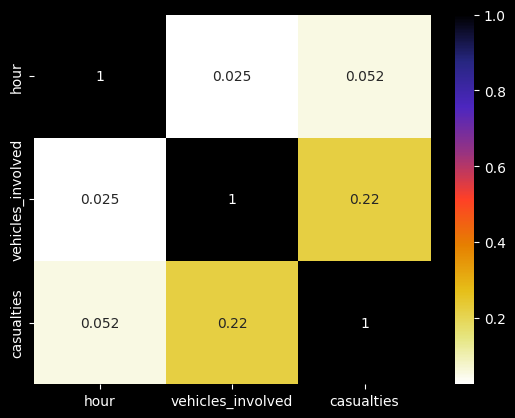

In [35]:
sns.heatmap(df_rta.corr(), annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

##### Data Imbalance check

In [36]:
# check for imbalanced dataset

moderate_imb = []
high_imb = []

for col in df_rta.columns:
    try:
        if (df_rta[col].value_counts() / df_rta.shape[0]).max() > 0.9:
            high_imb.append(col)
        elif (df_rta[col].value_counts() / df_rta.shape[0]).max() > 0.7 and col not in high_imb:
            moderate_imb.append(col)
    except Exception as e:
        print(f"Couldn't check \033[1m{col}\033[0m. ", e, "\n")

print("=" * 20, "\033[1m Imbalanced features\033[0m", "=" * 20)
print("No of moderately imbalanced features (75%+ data on a single class): ", len(moderate_imb), "\n")
print(moderate_imb, "\n")
print("No of highly imbalanced features (90%+ data on a single class): ", len(high_imb), "\n")
print(high_imb)

====================  Imbalanced features ====================
No of moderately imbalanced features (75%+ data on a single class):  1 

['accident_severity'] 

No of highly imbalanced features (90%+ data on a single class):  0 

[]


In [37]:
# train test split
X = df_rta.drop('accident_severity', axis=1)
y = df_rta['accident_severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8621, 18) (3695, 18) (8621,) (3695,)


##### Upsampling target variable

In [38]:
# percentage distribution of target variable values
counter = Counter(y_train)

print('----------- Before Upsampling ------------------')
for k, v in counter.items():
    pct_val = v / len(y_train) * 100
    print(f"class = {k}, count = {v}, ({pct_val:.2f}%)")

print('\n', '----------- After Upsampling ------------------')
# upsampling using SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)

for k, v in counter.items():
    pct_val = v / len(y_train) * 100
    print(f"class = {k}, count = {v}, ({pct_val:.2f}%)")    

----------- Before Upsampling ------------------
class = 0, count = 120, (1.39%)
class = 2, count = 7300, (84.68%)
class = 1, count = 1201, (13.93%)

 ----------- After Upsampling ------------------
class = 0, count = 7300, (33.33%)
class = 2, count = 7300, (33.33%)
class = 1, count = 7300, (33.33%)


#### Model

In [39]:
def apply_model(X_train, y_train, X_test, y_test, **kwargs):
    scores = {}
    models = []

    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb = XGBClassifier(enable_categorical=True)
        xgb.fit(X_train, np.ravel(y_train, order='C'))
        y_pred = xgb.predict(X_test)
        scores['xgb']= [accuracy_score(y_test, y_pred)]
        models.append(xgb)


    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf = RandomForestClassifier(n_estimators=200)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        scores['rf']= [accuracy_score(y_test, y_pred)]
        models.append(rf)

    if 'extree' in kwargs.keys() and kwargs['extree']:
        extree = ExtraTreesClassifier()
        extree.fit(X_train, y_train)
        y_pred = extree.predict(X_test)
        scores['extree'] = [accuracy_score(y_test, y_pred)]
        models.append(extree)
        
    return scores,models

In [40]:
scores,models = apply_model(X_train,y_train, X_test, y_test, xgb=True, rf=True, extree=True)
print(scores)

{'xgb': [0.7753721244925575], 'rf': [0.7851150202976996], 'extree': [0.7921515561569689]}


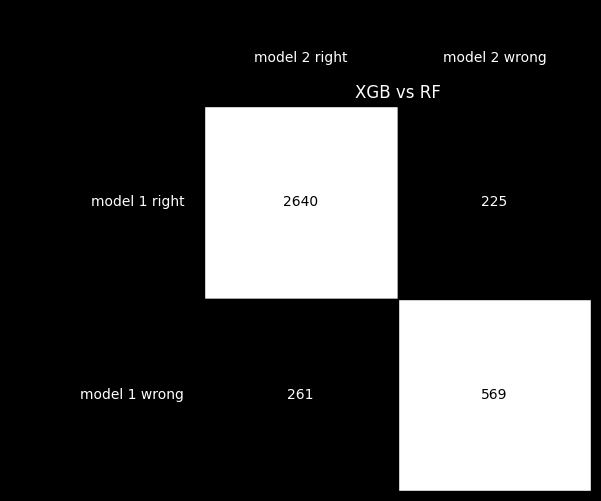

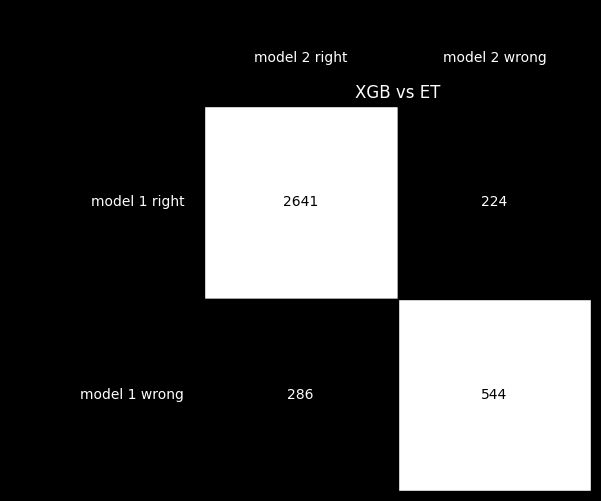

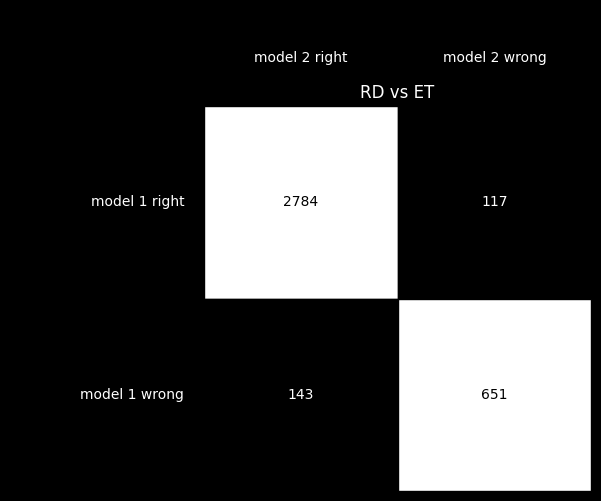

In [41]:
# predict
y_pred_xgb = models[0].predict(X_test)
y_pred_rf = models[1].predict(X_test)
y_pred_ext = models[2].predict(X_test)


tb = mcnemar_tables(y_test, 
                    y_pred_xgb,
                    y_pred_rf, 
                    y_pred_ext)

brd = checkerboard_plot(tb['model_0 vs model_1'],
                        figsize=(5, 5),
                        fmt='%d',
                        col_labels=['model 2 right', 'model 2 wrong'],
                        row_labels=['model 1 right', 'model 1 wrong'])
plt.title("XGB vs RF")
plt.show()

brd = checkerboard_plot(tb['model_0 vs model_2'],
                        figsize=(5, 5),
                        fmt='%d',
                        col_labels=['model 2 right', 'model 2 wrong'],
                        row_labels=['model 1 right', 'model 1 wrong'])
plt.title("XGB vs ET")
plt.show()

brd = checkerboard_plot(tb['model_1 vs model_2'],
                        figsize=(5, 5),
                        fmt='%d',
                        col_labels=['model 2 right', 'model 2 wrong'],
                        row_labels=['model 1 right', 'model 1 wrong'])
plt.title("RD vs ET")
plt.show()

In [42]:
def model_performance(model, y_test, y_hat) : 
    conf_matrix = confusion_matrix(y_test, y_hat)

    trace1 = go.Heatmap(z = conf_matrix, 
                        x = ["0 (pred)", "1 (pred)", "2 (pred)"],
                        y = ["0 (true)","1 (true)", "2 (true)"],
                        xgap = 2, 
                        ygap = 2, 
                        colorscale = 'tropic', 
                        showscale  = False,
                        text=conf_matrix,
                        hoverinfo='text')

    #Show metrics
    Accuracy  =  accuracy_score(y_test, y_hat)
    Precision =  precision_score(y_test, y_hat, average= 'weighted')
    Recall    =  recall_score(y_test, y_hat, average= 'weighted')
    F1_score  =  f1_score(y_test, y_hat, average= 'weighted')

    display_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    display_metrics = display_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (display_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(display_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
 
     
    #plots
    model = model
    
    #Subplots
    fig = tls.make_subplots(rows=2, cols=1, print_grid=False, 
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,2,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+ str(model),
                        autosize = True, height = 800,width = 800,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        # margin = dict(b = 100)
                        )
    fig.layout.titlefont.size = 14
    
    py.iplot(fig,filename='model-performance')

In [43]:
extree = ExtraTreesClassifier()
extree.fit(X_train, y_train)
y_pred = extree.predict(X_test)

In [44]:
extree.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [45]:
model_performance(extree,y_test, y_pred)

##### Hyperparameter Tuning

In [46]:
kf = KFold(n_splits=3, shuffle=True, random_state=42).split(X=X_train, y=y_train)

# parameter grid for ExtraTree
params = {
    'n_estimators': range(100, 500, 1000),
    'ccp_alpha': [0.0, 0.1],
    'criterion': ['gini'],
    'max_depth': [5, 11, 15],
    'min_samples_split': [2,3],
    'class_weight': ['balanced', None],
}

extree_estimator = ExtraTreesClassifier()

gs = GridSearchCV(
    estimator= extree_estimator,
    param_grid= params,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=kf,
    verbose=1,
)

extree_model = gs.fit(X=X_train, y=y_train)

print(gs.best_params_, gs.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100} 0.9021165883982487


In [47]:
# fitting the model with best params
extree_final = ExtraTreesClassifier(ccp_alpha = 0.0,
                                criterion = 'gini',
                                min_samples_split = 3,
                                class_weight = 'balanced',
                                max_depth = 15,
                                n_estimators = 100)

extree_final.fit(X_train, y_train)

ExtraTreesClassifier(class_weight='balanced', max_depth=15, min_samples_split=3)

##### Plotting important features

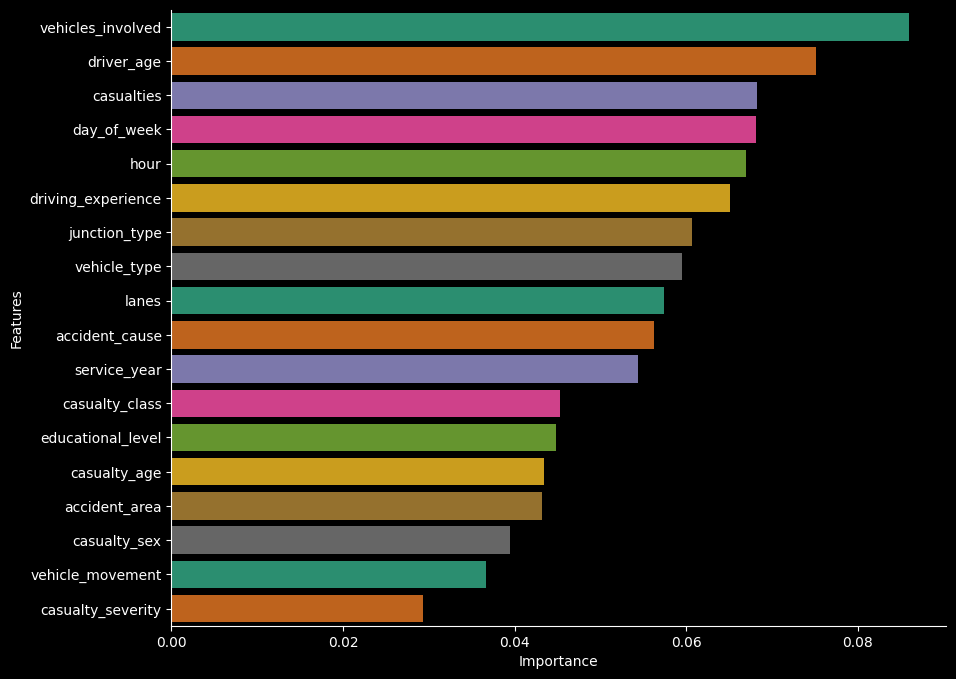

In [48]:
df_importance = pd.DataFrame()
df_importance['Features'] = X.columns
df_importance['Importance'] = extree_final.feature_importances_
plt.figure(figsize=(10, 8))
sns.barplot(data = df_importance.sort_values("Importance", ascending=False), y='Features', x='Importance', palette='Dark2');

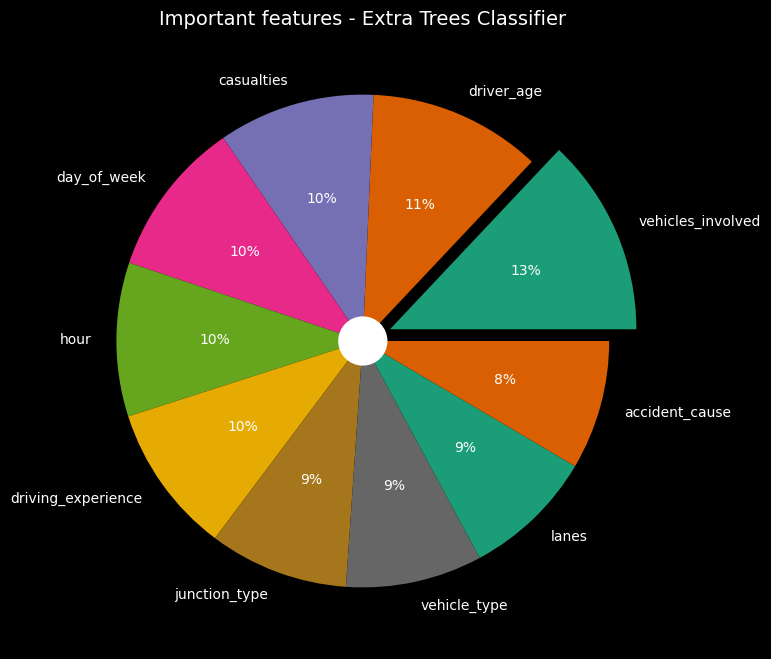

In [49]:
fi = pd.Series(extree_final.feature_importances_, index=X.columns)
colors = Dark2.colors[:10]
myexplode = [0.12,0,0,0,0,0,0,0,0,0]

plt.figure(figsize=(12,8))
plt.pie(fi.nlargest(10),
        labels = fi.nlargest(10).index, 
        autopct = '%.0f%%', 
        explode = myexplode,
        colors = colors,
        textprops={'fontsize': 10})

centre_circle = plt.Circle((0,0),0.10,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Important features - Extra Trees Classifier',fontsize=14)
plt.show()

For deploying the model, lets retrain the model using only top 10 features

In [50]:
top10 = list(df_importance.sort_values("Importance", ascending=False)['Features'].head(10).values)
df_rta_top10 = df_rta[top10]
df_rta_top10.head()

vehicles_involved driver_age  casualties day_of_week  hour  \
0                  1          0           1           1    17   
1                  1          1           1           1    17   
2                  1          0           1           1    17   
3                  1          0           1           3     1   
4                  1          0           1           3     1   

  driving_experience junction_type vehicle_type lanes accident_cause  
0                  0             1            0     2              9  
1                  3             1           11     4             16  
2                  0             1            5     6              0  
3                  2             7           11     6              1  
4                  1             7            0     6             16

In [51]:
X_train_t10, X_test_t10, y_train_t10, y_test_t10 = train_test_split(df_rta_top10, y, test_size=0.3, random_state=42)
print(X_train_t10.shape, X_test_t10.shape, y_train_t10.shape, y_test_t10.shape)

(8621, 10) (3695, 10) (8621,) (3695,)


In [52]:
# percentage distribution of target variable values
counter = Counter(y_train_t10)

print('----------- Before Upsampling ------------------')
for k, v in counter.items():
    pct_val = v / len(y_train_t10) * 100
    print(f"class = {k}, count = {v}, ({pct_val:.2f}%)")

print('\n', '----------- After Upsampling ------------------')
# upsampling using SMOTE
oversample = SMOTE()
X_train_t10, y_train_t10 = oversample.fit_resample(X_train_t10, y_train_t10)

counter = Counter(y_train_t10)

for k, v in counter.items():
    pct_val = v / len(y_train) * 100
    print(f"class = {k}, count = {v}, ({pct_val:.2f}%)")

----------- Before Upsampling ------------------
class = 2, count = 7324, (84.96%)
class = 1, count = 1191, (13.82%)
class = 0, count = 106, (1.23%)

 ----------- After Upsampling ------------------
class = 2, count = 7324, (33.44%)
class = 1, count = 7324, (33.44%)
class = 0, count = 7324, (33.44%)


In [53]:
extree_final.fit(X_train_t10, y_train_t10)

ExtraTreesClassifier(class_weight='balanced', max_depth=15, min_samples_split=3)

In [54]:
y_pred_t0 = extree_final.predict(X_test_t10)

In [55]:
model_performance(extree_final, y_test, y_pred)

In [56]:
print(X_train_t10.columns)
print(extree_final.feature_importances_)

Index(['vehicles_involved', 'driver_age', 'casualties', 'day_of_week', 'hour',
       'driving_experience', 'junction_type', 'vehicle_type', 'lanes',
       'accident_cause'],
      dtype='object')
[0.11309961 0.09858971 0.10915071 0.11796985 0.11540641 0.08987765
 0.08617787 0.0881339  0.08515825 0.09643605]


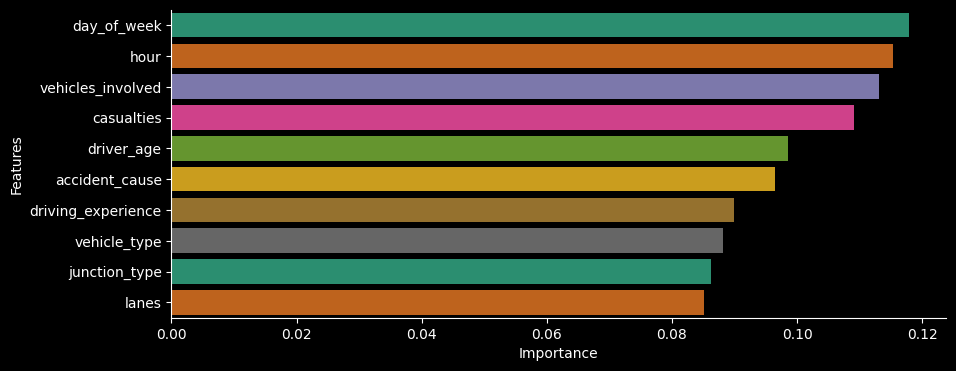

In [57]:
df_importance = pd.DataFrame()
df_importance['Features'] = X_train_t10.columns
df_importance['Importance'] = extree_final.feature_importances_
plt.figure(figsize=(10, 4))
sns.barplot(data = df_importance.sort_values("Importance", ascending=False), y='Features', x='Importance', palette='Dark2');

##### Saving the model

In [58]:
joblib.dump(extree_final, '..\model\extratree.joblib')

['..\\model\\extratree.joblib']